In [1]:
from datetime import datetime, timedelta

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
# Importing Time Series Data

# Data by the hour
first_48_data = pd.read_csv('../../../../data/datasets/mimiciv_timeseries/mimiciv_timeseries.csv')


first_48_data.head()

,Unnamed: 0,subject,time(hr),Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,...,x3_8.0,x3_9.0,x3_nan,x4_Confused,x4_Inappropriate Words,x4_Incomprehensible sounds,x4_No Response,x4_No Response-ETT,x4_Oriented,x4_nan
0,0,11432534_episode1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,11432534_episode1,0.010556,NaN,NaN,NaN,84.0,NaN,NaN,93.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,11432534_episode1,0.027222,42.0,NaN,NaN,84.0,NaN,53.0,93.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,11432534_episode1,0.060556,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,11432534_episode1,0.143889,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
for idx, row in first_48_data.iterrows():
        
    # Making gcs scores nan where unobserved
    if row['x0_nan'] == 1:
        first_48_data.at[idx, 'x0_0.0'] = np.nan
        first_48_data.at[idx, 'x0_1.0'] = np.nan

    if row['x1_nan'] == 1:
        first_48_data.at[idx, 'x1_None'] = np.nan
        first_48_data.at[idx, 'x1_Spontaneously'] = np.nan
        first_48_data.at[idx, 'x1_To Pain'] = np.nan
        first_48_data.at[idx, 'x1_To Speech'] = np.nan

    if row['x2_nan'] == 1:
        first_48_data.at[idx, 'x2_Abnormal Flexion'] = np.nan
        first_48_data.at[idx, 'x2_Abnormal extension'] = np.nan
        first_48_data.at[idx, 'x2_Flex-withdraws'] = np.nan
        first_48_data.at[idx, 'x2_Localizes Pain'] = np.nan
        first_48_data.at[idx, 'x2_No response'] = np.nan
        first_48_data.at[idx, 'x2_Obeys Commands'] = np.nan

    if row['x3_nan'] == 1:
        first_48_data.at[idx, 'x3_10.0'] = np.nan 
        first_48_data.at[idx, 'x3_11.0'] = np.nan
        first_48_data.at[idx, 'x3_12.0'] = np.nan
        first_48_data.at[idx, 'x3_13.0'] = np.nan
        first_48_data.at[idx, 'x3_14.0'] = np.nan
        first_48_data.at[idx, 'x3_15.0'] = np.nan
        first_48_data.at[idx, 'x3_3.0'] = np.nan
        first_48_data.at[idx, 'x3_4.0'] = np.nan
        first_48_data.at[idx, 'x3_5.0'] = np.nan
        first_48_data.at[idx, 'x3_6.0'] = np.nan
        first_48_data.at[idx, 'x3_7.0'] = np.nan
        first_48_data.at[idx, 'x3_8.0'] = np.nan
        first_48_data.at[idx, 'x3_9.0'] = np.nan


    if row['x4_nan'] == 1:
        first_48_data.at[idx, 'x4_Confused'] = np.nan
        first_48_data.at[idx, 'x4_Inappropriate Words'] = np.nan
        first_48_data.at[idx, 'x4_Incomprehensible sounds'] = np.nan
        first_48_data.at[idx, 'x4_No Response'] = np.nan
        first_48_data.at[idx, 'x4_No Response-ETT'] = np.nan
        first_48_data.at[idx, 'x4_Oriented'] = np.nan
            


In [5]:
first_48_data.head()

,Unnamed: 0,subject,time(hr),Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,...,x3_8.0,x3_9.0,x3_nan,x4_Confused,x4_Inappropriate Words,x4_Incomprehensible sounds,x4_No Response,x4_No Response-ETT,x4_Oriented,x4_nan
0,0,11432534_episode1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,11432534_episode1,0.010556,NaN,NaN,NaN,84.0,NaN,NaN,93.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,11432534_episode1,0.027222,42.0,NaN,NaN,84.0,NaN,53.0,93.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,11432534_episode1,0.060556,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,11432534_episode1,0.143889,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Reading label data

label_data = pd.read_csv('mimic_iv_label_data.csv')
label_data.head()

,Unnamed: 0,subject,subject_id,episode_num,readmission,length_of_stay,mortality
0,0,11432534_episode1,11432534,1,0.0,7.935417,0
1,1,18664949_episode1,18664949,1,0.0,5.114583,0
2,2,19793183_episode1,19793183,1,0.0,20.467361,0
3,3,15687156_episode1,15687156,1,0.0,0.098611,1
4,4,14504982_episode1,14504982,1,0.0,9.854167,0


In [7]:
# Reading patient clusters

patient_clusters = pd.read_csv('mimic_iv_patient_clusters.csv')
patient_clusters.head()

,Unnamed: 0,subject_id,cluster
0,0,10000032,1
1,1,10000980,1
2,2,10001217,1
3,3,10001725,1
4,4,10002013,1


In [8]:
# adding column for subject_id and episode_num

subject_w_ep = first_48_data['subject']

subject_ids = subject_w_ep.apply(lambda x: int(x.split('_')[0]))
episode_nums = subject_w_ep.apply(lambda x: int(x.split('_')[1][7:]))

In [9]:
first_48_data['subject_id'] = subject_ids
first_48_data['episode_num'] = episode_nums

first_48_data.head()

,Unnamed: 0,subject,time(hr),Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,...,x3_nan,x4_Confused,x4_Inappropriate Words,x4_Incomprehensible sounds,x4_No Response,x4_No Response-ETT,x4_Oriented,x4_nan,subject_id,episode_num
0,0,11432534_episode1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11432534,1
1,1,11432534_episode1,0.010556,NaN,NaN,NaN,84.0,NaN,NaN,93.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11432534,1
2,2,11432534_episode1,0.027222,42.0,NaN,NaN,84.0,NaN,53.0,93.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11432534,1
3,3,11432534_episode1,0.060556,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11432534,1
4,4,11432534_episode1,0.143889,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11432534,1


In [10]:
first_48_data.rename(columns={"time(hr)": "Hours"}, inplace=True)

In [11]:
# Merging data with labels and cluster to get correct sample

first_48_data = first_48_data.merge(label_data, on=['subject', 'subject_id', 'episode_num'])
first_48_data = first_48_data.merge(patient_clusters, on='subject_id')

first_48_data.head()

,Unnamed: 0_x,subject,Hours,Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,...,x4_Oriented,x4_nan,subject_id,episode_num,Unnamed: 0_y,readmission,length_of_stay,mortality,Unnamed: 0,cluster
0,0,11432534_episode1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,11432534,1,0,0.0,7.935417,0,3710,1
1,1,11432534_episode1,0.010556,NaN,NaN,NaN,84.0,NaN,NaN,93.0,...,NaN,1.0,11432534,1,0,0.0,7.935417,0,3710,1
2,2,11432534_episode1,0.027222,42.0,NaN,NaN,84.0,NaN,53.0,93.0,...,NaN,1.0,11432534,1,0,0.0,7.935417,0,3710,1
3,3,11432534_episode1,0.060556,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,NaN,1.0,11432534,1,0,0.0,7.935417,0,3710,1
4,4,11432534_episode1,0.143889,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,0.0,11432534,1,0,0.0,7.935417,0,3710,1


In [12]:
print(len(first_48_data.groupby('subject')))

31489


In [13]:
print(first_48_data.columns)

Index(['Unnamed: 0_x', 'subject', 'Hours', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH', 'x0_0.0',
       'x0_1.0', 'x0_nan', 'x1_None', 'x1_Spontaneously', 'x1_To Pain',
       'x1_To Speech', 'x1_nan', 'x2_Abnormal Flexion',
       'x2_Abnormal extension', 'x2_Flex-withdraws', 'x2_Localizes Pain',
       'x2_No response', 'x2_Obeys Commands', 'x2_nan', 'x3_10.0', 'x3_11.0',
       'x3_12.0', 'x3_13.0', 'x3_14.0', 'x3_15.0', 'x3_3.0', 'x3_4.0',
       'x3_5.0', 'x3_6.0', 'x3_7.0', 'x3_8.0', 'x3_9.0', 'x3_nan',
       'x4_Confused', 'x4_Inappropriate Words', 'x4_Incomprehensible sounds',
       'x4_No Response', 'x4_No Response-ETT', 'x4_Oriented', 'x4_nan',
       'subject_id', 'episode_num', 'Unnamed: 0_y', 'readmission',
       'length_of_stay', 'mortality', 'Unnamed: 0', 'cluster'],
      dtype='o

In [14]:
# keeping 'Unnamed: 0_x' and renaming to 'original_idx' to retain original indexes
first_48_data = first_48_data.drop(columns=['Unnamed: 0_y', 'Unnamed: 0'])

first_48_data = first_48_data.rename(columns={'Unnamed: 0_x': 'original_idx'})

In [15]:
print(first_48_data.columns)

Index(['original_idx', 'subject', 'Hours', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH', 'x0_0.0',
       'x0_1.0', 'x0_nan', 'x1_None', 'x1_Spontaneously', 'x1_To Pain',
       'x1_To Speech', 'x1_nan', 'x2_Abnormal Flexion',
       'x2_Abnormal extension', 'x2_Flex-withdraws', 'x2_Localizes Pain',
       'x2_No response', 'x2_Obeys Commands', 'x2_nan', 'x3_10.0', 'x3_11.0',
       'x3_12.0', 'x3_13.0', 'x3_14.0', 'x3_15.0', 'x3_3.0', 'x3_4.0',
       'x3_5.0', 'x3_6.0', 'x3_7.0', 'x3_8.0', 'x3_9.0', 'x3_nan',
       'x4_Confused', 'x4_Inappropriate Words', 'x4_Incomprehensible sounds',
       'x4_No Response', 'x4_No Response-ETT', 'x4_Oriented', 'x4_nan',
       'subject_id', 'episode_num', 'readmission', 'length_of_stay',
       'mortality', 'cluster'],
      dtype='object')


In [16]:
print(first_48_data.columns[3:-6])

Index(['Diastolic blood pressure', 'Fraction inspired oxygen', 'Glucose',
       'Heart Rate', 'Height', 'Mean blood pressure', 'Oxygen saturation',
       'Respiratory rate', 'Systolic blood pressure', 'Temperature', 'Weight',
       'pH', 'x0_0.0', 'x0_1.0', 'x0_nan', 'x1_None', 'x1_Spontaneously',
       'x1_To Pain', 'x1_To Speech', 'x1_nan', 'x2_Abnormal Flexion',
       'x2_Abnormal extension', 'x2_Flex-withdraws', 'x2_Localizes Pain',
       'x2_No response', 'x2_Obeys Commands', 'x2_nan', 'x3_10.0', 'x3_11.0',
       'x3_12.0', 'x3_13.0', 'x3_14.0', 'x3_15.0', 'x3_3.0', 'x3_4.0',
       'x3_5.0', 'x3_6.0', 'x3_7.0', 'x3_8.0', 'x3_9.0', 'x3_nan',
       'x4_Confused', 'x4_Inappropriate Words', 'x4_Incomprehensible sounds',
       'x4_No Response', 'x4_No Response-ETT', 'x4_Oriented', 'x4_nan'],
      dtype='object')


In [17]:
first_48_data.head()

,original_idx,subject,Hours,Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,...,x4_No Response,x4_No Response-ETT,x4_Oriented,x4_nan,subject_id,episode_num,readmission,length_of_stay,mortality,cluster
0,0,11432534_episode1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,11432534,1,0.0,7.935417,0,1
1,1,11432534_episode1,0.010556,NaN,NaN,NaN,84.0,NaN,NaN,93.0,...,NaN,NaN,NaN,1.0,11432534,1,0.0,7.935417,0,1
2,2,11432534_episode1,0.027222,42.0,NaN,NaN,84.0,NaN,53.0,93.0,...,NaN,NaN,NaN,1.0,11432534,1,0.0,7.935417,0,1
3,3,11432534_episode1,0.060556,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,NaN,NaN,NaN,1.0,11432534,1,0.0,7.935417,0,1
4,4,11432534_episode1,0.143889,42.0,NaN,NaN,86.0,NaN,53.0,92.0,...,0.0,0.0,0.0,0.0,11432534,1,0.0,7.935417,0,1


In [18]:
# Grouping by admission

data = first_48_data.groupby('subject')
print(len(data))

31489


In [19]:
i = 0  

subjects = []
subject_idx = []
readm_label = []
mortality_label = []
los_label = []
cluster = []


for group_idx, group_rows in data:  
    
    subjects.append(group_idx)
    subject_idx.append(i)
    
    readm_label.append(group_rows['readmission'].values[0])
    mortality_label.append(group_rows['mortality'].values[0])
    los_label.append(group_rows['length_of_stay'].values[0])
    cluster.append(group_rows['cluster'].values[0])
    
    
    
    # stores totals for variables
    cur_matrix = np.empty([48, 48])
    cur_matrix[:] = np.nan

    # stores counts for variables
    cur_counts = np.empty([48, 48])
    cur_counts[:] = np.nan

    cur_columns = group_rows.columns.values.tolist()
    feature_columns = cur_columns[3:-6]

    j = 0
    for idx, row in group_rows.iterrows():
        
            
        # Modifying cur_data to have data by the hour for 48 hours
        if row['Hours'] < j+1 and j < 48:
            for k in range(len(feature_columns)):
                if not (np.isnan(group_rows.loc[idx, feature_columns[k]])):
                    if np.isnan(cur_matrix[j, k]):
                        cur_matrix[j, k] = group_rows.loc[idx, feature_columns[k]]
                        cur_counts[j, k] = 1
                    else:
                        cur_matrix[j, k] += group_rows.loc[idx, feature_columns[k]]
                        cur_counts[j, k] += 1
                        
        else:
            if j >= 48:
                break
            else:
                j += 1
                

    # Getting time series data

    X_element = np.divide(cur_matrix, cur_counts)

    if i == 0:

        # Holds all of the multivariate time series
        X = np.array([X_element])

    else:
        X = np.concatenate((X, np.array([X_element])))
    
    i += 1
    

In [20]:
print(X.shape)

(31489, 48, 48)


In [21]:
# Extracting more observed sequences

idxs = []

props = []

props_in_sample = []

for i in range(X.shape[0]):
    
    
    cur_matrix = X[i,:,:]

    flattened_matrix = cur_matrix.flatten()
    
    flattened_series = pd.Series(flattened_matrix)

    prop_unobserved = len(flattened_series.loc[np.isnan(flattened_series)]) / len(flattened_series) 
    props.append(prop_unobserved)

    if prop_unobserved < 0.2:
        idxs.append(i)
        props_in_sample.append(prop_unobserved)
        
print(len(idxs))
print("Overall missingness: ", np.mean(props), "\n")
print("Missingness in more observed samples: ", np.mean(props_in_sample), "\n")

503
Overall missingness:  0.7139147301438598 

Missingness in more observed samples:  0.11668875635078418 



In [22]:
X = X[idxs,:,:]


In [23]:
y = pd.DataFrame({'subject':subjects, 'subject_idx':subject_idx, 'readmission':readm_label, 'mortality':mortality_label,
                  'length_of_stay':los_label, 'cluster':cluster})
subjects = []
subject_idx = []
readm_label = []
mortality_label = []
los_label = []
cluster = []

print(y.shape)
y.head()

(31489, 6)


,subject,subject_idx,readmission,mortality,length_of_stay,cluster
0,10000032_episode1,0,0.0,0,2.222222,1
1,10000980_episode1,1,0.0,0,5.806944,1
2,10001217_episode1,2,1.0,0,6.794444,1
3,10001217_episode2,3,NaN,0,5.914583,1
4,10001725_episode1,4,0.0,0,2.994444,1


In [24]:
y = y.loc[idxs]
y.head()

,subject,subject_idx,readmission,mortality,length_of_stay,cluster
72,10019777_episode1,72,0.0,0,16.767361,1
120,10038081_episode1,120,0.0,1,14.138889,1
142,10048001_episode3,142,NaN,0,6.665972,1
158,10054277_episode1,158,0.0,0,8.947222,1
219,10080961_episode1,219,0.0,0,17.791667,1


In [25]:
from sklearn.model_selection import train_test_split

random_seed = 33

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [26]:
from sklearn import preprocessing

# Standardizing the data

scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = preprocessing.StandardScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_test.shape[2]):
    X_test[:, :, i] = scalers[i].transform(X_test[:, :, i]) 

for i in range(X.shape[2]):
    X[:, :, i] = scalers[i].transform(X[:, :, i]) 

    

In [27]:
from sklearn import preprocessing

# Standardizing the data

train_minmax_scalers = {}



for i in range(X_train_minmax.shape[2]):
    train_minmax_scalers[i] = preprocessing.MinMaxScaler()
    X_train_minmax[:, :, i] = train_minmax_scalers[i].fit_transform(X_train_minmax[:, :, i]) 

for i in range(X_test_minmax.shape[2]):
    X_test_minmax[:, :, i] = train_minmax_scalers[i].transform(X_test_minmax[:, :, i]) 


    

In [28]:
from sklearn.impute import SimpleImputer


print(X.shape)

all_feature_means = []

# Reshaping to 2-dimensional data for imputation
X_2d = np.reshape(X, (X.shape[0]*X.shape[1], X.shape[2]))


mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imputer.fit(X_2d)
X_2d = mean_imputer.transform(X_2d)


for i in range(X_2d.shape[1]):
    all_feature_means.append(np.mean(X_2d[:][i]))



print(all_feature_means)

(503, 48, 48)
[0.1008474384851535, -0.009839816180565222, 0.4465087020166753, -0.04028108531610427, 0.004436633246742992, -0.0006324717186075764, -0.010035731632010797, 0.049367177388261796, -0.009839816180565222, 0.047535036119595364, -0.03163723747048672, 0.013278458457099998, -0.005349788890249156, -0.001149356985517815, 0.039871366646355426, 0.027730812807314247, 0.06578873852242385, 0.09566301468650718, 0.06843730963621754, 0.007257287473653423, -0.004056038981423898, -0.009839816180565222, 0.06792886930665248, 0.08890024355195154, -0.01705183627436635, -0.03945357011761232, -0.03450202471860697, -0.02722783221832657, -0.029921088132459594, -0.031397896178470636, -0.04576201607821401, -0.04960253126663431, -0.05036111450310299, -0.06082962477373569, -0.0666224676444671, -0.06848101637117618, -0.0915765117550585, -0.08678810157694287, -0.04829619954588055, -0.03327371635926144, -0.04376088974067566, -0.07425859428453403, -0.08588975960240035, -0.009839816180565222, -0.0098398161805

In [29]:



print(X.shape)

train_feature_means = []

# Reshaping to 2-dimensional data for imputation
X_train_2d = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))


train_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_mean_imputer.fit(X_train_2d)
X_train_2d = train_mean_imputer.transform(X_train_2d)


for i in range(X_train_2d.shape[1]):
    train_feature_means.append(np.mean(X_train_2d[:][i]))



print(train_feature_means)

(503, 48, 48)
[-0.04370821554881273, -0.06326523988469764, -0.09074172839210155, -0.05179448315229875, -0.04457860973674408, -0.05741266590642132, -0.04889665502028307, -0.123854021366981, -1.2213807418900122e-16, -0.04014206218843929, -0.014116727938208768, 0.03769024123277858, -1.2213807418900122e-16, -0.005132757689000536, 0.15095737231317433, 0.04825915070104827, 0.0523222618584886, 0.03390838945090374, 0.04008344938357662, -0.06992275231488444, 0.021883354992353176, -0.08186312349999082, -0.0710193876710042, -0.10058135234096094, -0.038625734209505706, -0.03791259647809228, -0.03343326657825388, -0.0038383679569045925, 0.06974424648213351, 0.0012886800955950646, 0.01951048414084754, -0.052753589013548506, -0.01529230703537108, -0.04762089691474342, -0.03417563664587722, 0.03045340251984773, -0.0858715473344326, 0.0022296611528718757, -0.04699212964732524, -0.005276585765169715, -0.019623609397297414, 0.017155906563545088, 0.05403531993496241, -0.014439329245338728, 0.1169113385204

In [30]:
from sklearn.impute import SimpleImputer


print(X.shape)

test_feature_means = []

# Reshaping to 2-dimensional data for imputation
X_test_2d = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2]))


test_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
test_mean_imputer.fit(X_test_2d)
X_test_2d = test_mean_imputer.transform(X_test_2d)


for i in range(X_test_2d.shape[1]):
    test_feature_means.append(np.mean(X_test_2d[:][i]))



print(test_feature_means)

(503, 48, 48)
[0.17978906575944878, -0.0469914166333379, -0.038579958270870185, -0.01768487862479687, -0.07352666894477142, -0.006890047072223543, 0.03152075593228532, -0.04357566504338392, -0.06881092649496805, -0.0350763067398119, -0.07444412368695201, -0.06755312068350479, 0.005217816650605389, -0.09710098325535244, -0.055634325184662915, 0.026061446374716926, 0.01163300674302121, -0.046719327861834276, 0.003926091996108448, -0.06872199019280416, -0.016151735377329057, -0.02070519661168997, -0.04044234970777171, -0.01683127410438134, -0.03582980449624557, -0.06895404169781451, -0.10796897913552111, -0.07427039889809484, -0.02838221780865156, 0.03001721120524246, 0.007071473799392898, -0.013362059743543106, 0.08762758424851663, 0.03307716606943529, -0.01572330525992439, 0.11687409620882437, 0.06886804111854723, 0.021333577464583402, 0.06362921240131901, -0.0032624013689174967, 0.03683237031348819, -0.07601168501944383, -0.058795212830304706, -0.0051600849637185265, -0.028583154020954

In [31]:



print(X.shape)

train_feature_means_minmax = []

# Reshaping to 2-dimensional data for imputation
X_train_2d_minmax = np.reshape(X_train_minmax, (X_train_minmax.shape[0]*X_train_minmax.shape[1], X_train_minmax.shape[2]))


train_mean_imputer_minmax = SimpleImputer(missing_values=np.nan, strategy='mean')
train_mean_imputer_minmax.fit(X_train_2d_minmax)
X_train_2d_minmax = train_mean_imputer_minmax.transform(X_train_2d_minmax)


for i in range(X_train_2d.shape[1]):
    train_feature_means_minmax.append(np.mean(X_train_2d_minmax[:][i]))



print(train_feature_means_minmax)

(503, 48, 48)
[0.286944895064253, 0.24783517976920588, 0.22632800019453317, 0.2522047842620026, 0.23745737064221428, 0.23810278706018292, 0.24116956698761238, 0.22975369414699598, 0.2269161128669485, 0.24063531183428735, 0.2404823683486719, 0.24681804330485424, 0.2269161128669485, 0.2491216010045596, 0.27281273219022967, 0.2506218282845967, 0.26102314535949145, 0.24459295195483036, 0.2548871398765087, 0.22171013726917285, 0.23033231894551184, 0.22283445056827847, 0.2291326968353773, 0.2126270210790564, 0.2247300104707667, 0.22560368071828082, 0.22782250840819462, 0.23633502844112853, 0.24295643452671803, 0.23214751950415854, 0.23745356410521548, 0.21989314028982684, 0.22278734526664157, 0.22162254296865236, 0.23105509948744699, 0.2424532781346321, 0.21952886518734918, 0.23578586823543377, 0.22454951151557956, 0.2357542313218365, 0.23498964820670065, 0.2229408097329009, 0.24402888826600702, 0.23677317123624717, 0.2508951877904754, 0.22735500738991724, 0.24256303854912545, 0.220748249930

In [32]:
def create_mean_imputed_data(X_train, X_test, train_feature_means, test_feature_means):
    impute_value = 0.

    X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

    train_mask = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    test_mask = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[1]):
            for k in range(X_train.shape[2]):
                if np.isnan(X_train[i,j,k]):
                    X_train_imputed[i,j,k] = train_feature_means[k]
                    train_mask[i,j,k] = 0
                else:
                    X_train_imputed[i,j,k] = X_train[i,j,k]
                    train_mask[i,j,k] = 1


    for i in range(X_test.shape[0]):
        for j in range(X_test.shape[1]):
            for k in range(X_test.shape[2]):
                if np.isnan(X_test[i,j,k]):
                    X_test_imputed[i,j,k] = train_feature_means[k]
                    test_mask[i,j,k] = 0
                else:
                    X_test_imputed[i,j,k] = X_test[i,j,k]
                    test_mask[i,j,k] = 1

    return X_train_imputed, X_test_imputed
    

In [33]:
X_train_mean_imputed, X_test_mean_imputed = create_mean_imputed_data(X_train_minmax, X_test_minmax, 
                                                                     train_feature_means_minmax, train_feature_means_minmax)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
n_est = 8
max_depth = 25

estimator =  RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, bootstrap=True, 
                                  random_state=random_seed)
X_train_2d = np.reshape(X_train_minmax, (X_train_minmax.shape[0]*X_train_minmax.shape[1], X_train_minmax.shape[2]))

miss_forest_imputer = IterativeImputer(random_state=random_seed, estimator=estimator, max_iter=10)


In [35]:
miss_forest_imputer.fit(X_train_2d)

/home/ugrads/c/clearloveyanzhen/miniconda3/envs/jeroda7105/lib/python3.9/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=RandomForestRegressor(max_depth=25, n_estimators=8,
                                                 random_state=33),
                 random_state=33)

In [36]:
def create_mf_imputed_data(X_train, X_test, miss_forest_impute):
    

    X_train_2d = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))

    X_train_imputed_2d = miss_forest_imputer.transform(X_train_2d)
    X_train_imputed = np.reshape(X_train_imputed_2d, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    

    X_test_2d = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2])) 

    X_test_imputed_2d = miss_forest_imputer.transform(X_test_2d)
    X_test_imputed = np.reshape(X_test_imputed_2d, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    return X_train_imputed, X_test_imputed
    

In [37]:
X_train_mf_imputed, X_test_mf_imputed = create_mf_imputed_data(X_train, X_test, miss_forest_imputer)

In [38]:
def vae_preprocessing(X_train, X_test):
    impute_value = 0.

    X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

    train_mask = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    test_mask = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[1]):
            for k in range(X_train.shape[2]):
                if np.isnan(X_train[i,j,k]):
                    X_train_imputed[i,j,k] = impute_value
                    train_mask[i,j,k] = 0
                else:
                    X_train_imputed[i,j,k] = X_train[i,j,k]
                    train_mask[i,j,k] = 1


    for i in range(X_test.shape[0]):
        for j in range(X_test.shape[1]):
            for k in range(X_test.shape[2]):
                if np.isnan(X_test[i,j,k]):
                    X_test_imputed[i,j,k] = impute_value
                    test_mask[i,j,k] = 0
                else:
                    X_test_imputed[i,j,k] = X_test[i,j,k]
                    test_mask[i,j,k] = 1
                    
    return X_train_imputed, X_test_imputed, train_mask, test_mask

In [39]:
processed_X_train, processed_X_test, train_mask, test_mask = vae_preprocessing(X_train_minmax, X_test_minmax)

In [40]:
from abc import ABC, abstractmethod

class vae_model(ABC):

    def __init__(self, n_filters, kernel_size, learning_rate,
               sequence_length, n_features):
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate

        self.latent_dim = 2
        self.sequence_length = sequence_length
        self.n_features = n_features
    

        if self.kernel_size == 3:
            self.nn_dim = 21
        elif self.kernel_size == 5:
            self.nn_dim = 18
        else:
            self.kernel_size = 3
            self.nn_dim = 21

    def set_seed(self, seed):
    
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)

    def sampling(self, args):
      
        latent_dim = 2
        z_mean, z_log_sigma = args
        batch_size = tf.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1)

        return z_mean + K.exp(0.5 * z_log_sigma) * epsilon


    def vae_loss(self, inp, mask, out, z_log_sigma, z_mean):
        masked_input = tf.math.multiply(inp, mask)
        masked_output = tf.math.multiply(out, mask)

        #mse = np.sum(np.square(np.subtract(masked_output, masked_input))) / np.sum(mask)
        mse = K.sum(K.square(masked_output - masked_input)) / K.sum(mask)

        reconstruction = mse * self.sequence_length
        kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

        return reconstruction + kl

    @abstractmethod
    def get_model(self):
        pass
   


In [41]:
class cnn_vae(vae_model):

    def get_model(self):
  

        self.set_seed(random_seed)

        # encoder

        inp = tf.keras.Input(shape=(self.sequence_length, self.n_features))
        mask = tf.keras.Input(shape=(self.sequence_length, self.n_features))


        conv = tf.keras.layers.Conv1D(filters = self.n_filters, kernel_size = self.kernel_size, activation='relu')(inp)
        print(conv.shape)

        max_pool = tf.keras.layers.MaxPool1D(pool_size = 2)(conv) 

        conv = tf.keras.layers.Conv1D(filters = self.n_filters/2, kernel_size = self.kernel_size, activation='relu')(max_pool)
        print(conv.shape)

        enc = tf.keras.layers.Flatten()(conv)

        enc = tf.keras.layers.Dense(self.nn_dim*8, activation="relu")(enc)

        enc = tf.keras.layers.Dense(self.nn_dim*4, activation="relu")(enc)

        enc = tf.keras.layers.Dense(self.nn_dim*2, activation="relu")(enc)

        z = tf.keras.layers.Dense(self.nn_dim, activation="relu")(enc)

        z_mean = tf.keras.layers.Dense(self.latent_dim)(z)
        z_log_sigma = tf.keras.layers.Dense(self.latent_dim)(z)

        encoder = tf.keras.Model([inp], [z_mean, z_log_sigma])

        # decoder

        inp_z = tf.keras.Input(shape=(self.latent_dim,))

        dec = tf.keras.layers.Dense(self.nn_dim)(inp_z)

        dec = tf.keras.layers.Dense(self.nn_dim*2)(dec)

        dec = tf.keras.layers.Dense(self.nn_dim*4)(dec)

        dec = tf.keras.layers.Dense(self.nn_dim*8)(dec)

        dec = tf.keras.layers.Reshape((self.nn_dim, 8))(dec)

        deconv = tf.keras.layers.Conv1DTranspose(filters=self.n_filters/2, kernel_size=self.kernel_size)(dec)
        print(deconv.shape)

        upsample = tf.keras.layers.UpSampling1D(2)(deconv)

        deconv = tf.keras.layers.Conv1DTranspose(filters=self.n_features, kernel_size=self.kernel_size)(upsample)
        print(deconv.shape)


        out = deconv


        decoder = tf.keras.Model([inp_z], out) 

        # encoder and decoder 

        z_mean, z_log_sigma = encoder([inp])
        z = tf.keras.layers.Lambda(self.sampling)([z_mean, z_log_sigma])
        pred = decoder([z])

        vae = tf.keras.Model([inp,  mask], pred)
        vae.add_loss(self.vae_loss(inp, mask, pred, z_log_sigma, z_mean))
        vae.compile(loss=None, optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))

        return vae

In [42]:
class lstm_vae(vae_model):
    
    def get_model(self):
      
        self.set_seed(random_seed)

        # encoder

        inp = tf.keras.Input(shape=(self.sequence_length, self.n_features))
        mask = tf.keras.Input(shape=(self.sequence_length, self.n_features))


        enc = tf.keras.layers.LSTM(192, input_shape=(self.sequence_length, self.n_features))(inp)

        z = tf.keras.layers.Dense(96, activation="relu")(enc)

        z_mean = tf.keras.layers.Dense(self.latent_dim)(z)
        z_log_sigma = tf.keras.layers.Dense(self.latent_dim)(z)

        encoder = tf.keras.Model([inp], [z_mean, z_log_sigma])

        # decoder

        inp_z = tf.keras.Input(shape=(self.latent_dim,))

        dec = tf.keras.layers.RepeatVector(self.sequence_length)(inp_z)

        dec = tf.keras.layers.LSTM(192, input_shape=(self.sequence_length, self.n_features), return_sequences=True)(dec)

        out = tf.keras.layers.TimeDistributed(Dense(self.n_features))(dec)

        decoder = tf.keras.Model([inp_z], out) 

        # encoder and decoder 

        z_mean, z_log_sigma = encoder([inp])
        z = tf.keras.layers.Lambda(self.sampling)([z_mean, z_log_sigma])
        pred = decoder([z])

        vae = tf.keras.Model([inp,  mask], pred)
        vae.add_loss(self.vae_loss(inp, mask, pred, z_log_sigma, z_mean))
        vae.compile(loss=None, optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))

        return vae

   

In [43]:
def train_eval_vae_model(model, processed_X_train, processed_X_test, train_mask, test_mask, batch_size):
  
    es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
    model.fit([processed_X_train, train_mask], batch_size=batch_size, validation_split=0.2, epochs=100, shuffle=False, callbacks=[es])


    vae = tf.keras.Model(model.input, model.output)

    reconstruc_train = vae.predict([processed_X_train,  train_mask])
    reconstruc_test = vae.predict([processed_X_test, test_mask])

    mse = 0
    mae = 0

    #print(mask_X_test_imputed[1])
    masked_reconstruction = tf.math.multiply(reconstruc_test, test_mask)



    for i in range(processed_X_test.shape[0]):
        mse += np.sum(np.square(np.subtract(processed_X_test[i], masked_reconstruction[i]))) / np.sum(test_mask[i])
        mae += np.sum(np.absolute(np.subtract(processed_X_test[i], masked_reconstruction[i]))) / np.sum(test_mask[i])


    print("test mse: ", mse / processed_X_test.shape[0])
    print("test mae: ", mae / processed_X_test.shape[0], "\n")

    return model, reconstruc_train, reconstruc_test


In [96]:
def all_eval(X, X_minmax, scalers, test_minmax_scalers, cnn_vae, lstm_vae, batch_size, miss_forest_imputer, train_feature_means, 
             knn_imputers, lstm_ae_model, mask_prop):
    # Creating a random mask for evaluation of imputation 

    iter = 30
    cnn_vae_mse_list = []
    cnn_vae_mae_list = []

    lstm_vae_mse_list = []
    lstm_vae_mae_list = []
    
    mf_mse_list = []
    mf_mae_list = []
    
    mean_mse_list = []
    mean_mae_list = []
    
    fill_mse_list = []
    fill_mae_list = []
    
    dynimp_mse_list = []
    dynimp_mae_list = []
    

    n_samples = X.shape[0]

    rand_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
    mask_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
    rand_mask = np.empty([X.shape[0], X.shape[1], X.shape[2]])

    for j in range(iter):

        for i in range(rand_X_imputed.shape[0]):
            rand_mask_1d = np.random.choice([0,1], size=X.shape[1]*X.shape[2], replace=True, p=[mask_prop, 1-mask_prop])
            rand_mask[i] = np.reshape(rand_mask_1d, (X.shape[1],X.shape[2]))

        rand_mask = np.where(np.isnan(X), 0, rand_mask)

        cnn_vae_mse = 0
        cnn_vae_mae = 0

        lstm_vae_mse = 0
        lstm_vae_mae = 0
        
        mf_mse = 0
        mf_mae = 0
        
        mean_mse = 0
        mean_mae = 0
        
        fill_mse = 0
        fill_mae = 0
        
        dynimp_mse = 0
        dynimp_mae = 0

        # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)



        ############################################ 
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, 0, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        
        # Performing and evaluating cnn_vae imputation
        cnn_vae_imputated_data = cnn_vae.predict([rand_X_imputed, rand_mask], batch_size=batch_size)


        # Only considering observations where actual was randomly masked out
        cnn_vae_imputated_data = np.where(rand_mask==0, cnn_vae_imputated_data, 0)
        cnn_vae_imputated_data = np.where(np.isnan(X), 0, cnn_vae_imputated_data)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)

        for i in range(rand_X_imputed.shape[0]):
            cnn_vae_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], cnn_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])
            cnn_vae_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], cnn_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])

        cnn_vae_mse_list.append(cnn_vae_mse / n_samples)
        cnn_vae_mae_list.append(cnn_vae_mae / n_samples)

        ############################################ 
        
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)

        # lstm_vae imputation
        rand_X_imputed = np.where(rand_mask==0, 0, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        
        # Performing and evaluating lstm_vae imputation
        lstm_vae_imputated_data = lstm_vae.predict([rand_X_imputed, rand_mask], batch_size=batch_size)


        # Only considering observations where actual was randomly masked out
        lstm_vae_imputated_data = np.where(rand_mask==0, lstm_vae_imputated_data, 0)
        lstm_vae_imputated_data = np.where(np.isnan(X), 0, lstm_vae_imputated_data)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)

        for i in range(rand_X_imputed.shape[0]):
            lstm_vae_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], lstm_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])
            lstm_vae_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], lstm_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])

        lstm_vae_mse_list.append(lstm_vae_mse / n_samples)
        lstm_vae_mae_list.append(lstm_vae_mae / n_samples)
        
        ############################################ 
        
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        
        # Performing and evaluating missforest imputation
        
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        # imputing on the random mask data
        rand_X_imputed_2d = np.reshape(rand_X_imputed, (rand_X_imputed.shape[0]*rand_X_imputed.shape[1], rand_X_imputed.shape[2]))

        mf_X_imputed_2d = miss_forest_imputer.transform(rand_X_imputed_2d)
        mf_X_imputed = np.reshape(mf_X_imputed_2d, (rand_X_imputed.shape[0], rand_X_imputed.shape[1], rand_X_imputed.shape[2]))

        #print(rand_X_test_imputed)

        # Only considering observations where actual was randomly masked out
        mf_X_imputed = np.where(rand_mask==0, mf_X_imputed, 0)
        mf_X_imputed = np.where(np.isnan(X), 0, mf_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            mf_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], mf_X_imputed[i]))) / np.sum(rand_error_mask[i])
            mf_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], mf_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        mf_mse_list.append(mf_mse / n_samples)
        mf_mae_list.append(mf_mae / n_samples)




        ############################################ 
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        
        # Performing and evaluating mean imputation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        mean_X_imputed = np.where(np.isnan(rand_X_imputed), train_feature_means,  rand_X_imputed)
        
        
        mean_X_imputed = np.where(rand_mask==0, mean_X_imputed, 0)
        mean_X_imputed = np.where(np.isnan(X), 0, mean_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            mean_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], mean_X_imputed[i]))) / np.sum(rand_error_mask[i])
            mean_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], mean_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        mean_mse_list.append(mean_mse / n_samples)
        mean_mae_list.append(mean_mae / n_samples)

        ############################################ 
         # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        # imputing on the random mask data
        
        for k in range(rand_X_imputed.shape[0]):
            intermediate_df = pd.DataFrame(rand_X_imputed[k,:,:])
            intermediate_df = intermediate_df.ffill()
            intermediate_df = intermediate_df.bfill()
            intermediate_array = intermediate_df.to_numpy()
            rand_X_imputed[k,:,:] = intermediate_array
        
        forward_X_imputed = np.where(np.isnan(rand_X_imputed), train_feature_means,  rand_X_imputed)

        #print(rand_X_test_imputed)

        # Only considering observations where actual was randomly masked out
        forward_X_imputed = np.where(rand_mask==0, forward_X_imputed, 0)
        forward_X_imputed = np.where(np.isnan(X), 0, forward_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            fill_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], forward_X_imputed[i]))) / np.sum(rand_error_mask[i])
            fill_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], forward_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        fill_mse_list.append(fill_mse / n_samples)
        fill_mae_list.append(fill_mae / n_samples)

        ############################################ 
         # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        # imputing on the random mask data
        
        rand_X_imputed_knn = np.empty([rand_X_imputed.shape[0], rand_X_imputed.shape[1], rand_X_imputed.shape[2]])
        rand_X_imputed_transposed = rand_X_imputed.transpose((1, 0, 2))

        for i in range(rand_X_imputed_transposed.shape[0]):

            cur_imputer = knn_imputers[i]

            rand_X_imputed_transposed[i] = cur_imputer.transform(rand_X_imputed_transposed[i])

        rand_X_imputed_knn = rand_X_imputed_transposed.transpose((1, 0, 2))

        dynimp_X_imputed = lstm_ae_model.predict(rand_X_imputed_knn, batch_size=batch_size)
        

        #print(rand_X_test_imputed)
        

        # Only considering observations where actual was randomly masked out
        dynimp_X_imputed = np.where(rand_mask==0, dynimp_X_imputed, 0)
        dynimp_X_imputed = np.where(np.isnan(X_minmax), 0, dynimp_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X_minmax), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X_minmax), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            dynimp_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], dynimp_X_imputed[i]))) / np.sum(rand_error_mask[i])
            dynimp_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], dynimp_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        dynimp_mse_list.append(dynimp_mse / n_samples)
        dynimp_mae_list.append(dynimp_mae / n_samples)

    print("fill mse:")
    print("mean: ", np.mean(fill_mse_list))
    print("std dev: ",np.std(fill_mse_list), "\n")


    print("fill_mae:")
    print("mean: ", np.mean(fill_mae_list))
    print("std dev: ",np.std(fill_mae_list), "\n")

        

        


    print("cnn-vae imputation mse:")
    print("mean: ", np.mean(cnn_vae_mse_list))
    print("std dev: ", np.std(cnn_vae_mse_list), "\n")

    print("cnn-vae imputation mae:")
    print("mean: ", np.mean(cnn_vae_mae_list))
    print("std dev: ", np.std(cnn_vae_mae_list), "\n\n")



    print("lstm-vae imputation mse:")
    print("mean: ", np.mean(lstm_vae_mse_list))
    print("std dev: ", np.std(lstm_vae_mse_list), "\n")

    print("lstm-vae imputation mae:")
    print("mean: ", np.mean(lstm_vae_mae_list))
    print("std dev: ", np.std(lstm_vae_mae_list), "\n\n")


    print("missforest imputation mse:")
    print("mean: ", np.mean(mf_mse_list))
    print("std dev: ", np.std(mf_mse_list), "\n")
    
    print("missforest imputation mae:")
    print("mean: ", np.mean(mf_mae_list))
    print("std dev: ", np.std(mf_mae_list), "\n\n")


    
    print("mean imputation mse:")
    print("mean: ", np.mean(mean_mse_list))
    print("std dev: ", np.std(mean_mse_list), "\n")
    
    print("mean imputation mae:")
    print("mean: ", np.mean(mean_mae_list))
    print("std dev: ", np.std(mean_mae_list), "\n\n")
    
    
    print("dynimp imputation mse:")
    print("mean: ", np.mean(dynimp_mse_list))
    print("std dev: ", np.std(dynimp_mse_list), "\n")
    
    print("dynimp imputation mae:")
    print("mean: ", np.mean(dynimp_mae_list))
    print("std dev: ", np.std(dynimp_mae_list), "\n\n")


    

In [45]:
cnn_vae_instance = cnn_vae(n_filters=32, kernel_size=5, learning_rate=1e-4, 
                                    sequence_length=48, n_features=48)


cnn_vae_model = cnn_vae_instance.get_model()

trained_cnn_vae_model, cnn_reconstruc_train, cnn_reconstruc_test = train_eval_vae_model(cnn_vae_model, 
                                                processed_X_train, processed_X_test, train_mask, test_mask, 1)



2022-06-04 00:57:33.734510: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-04 00:57:33.734598: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cse-stmi-s1.cse.tamu.edu
2022-06-04 00:57:33.734620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cse-stmi-s1.cse.tamu.edu
2022-06-04 00:57:33.734844: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-04 00:57:33.734935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-04 00:57:33.734950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-06-04 00:57:33.735626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use

(None, 44, 32)
(None, 18, 16)
(None, 22, 16)
(None, 48, 48)
Epoch 1/100
321/321 [==============================] - 3s 5ms/step - loss: 7.3585 - val_loss: 5.0330
Epoch 2/100
321/321 [==============================] - 1s 4ms/step - loss: 4.0451 - val_loss: 3.5097
Epoch 3/100
321/321 [==============================] - 1s 4ms/step - loss: 3.3190 - val_loss: 3.2591
Epoch 4/100
321/321 [==============================] - 1s 4ms/step - loss: 3.1689 - val_loss: 3.1937
Epoch 5/100
321/321 [==============================] - 1s 4ms/step - loss: 3.1007 - val_loss: 3.1314
Epoch 6/100
321/321 [==============================] - 1s 4ms/step - loss: 3.0438 - val_loss: 3.0565
Epoch 7/100
321/321 [==============================] - 1s 3ms/step - loss: 3.0193 - val_loss: 3.0475
Epoch 8/100
321/321 [==============================] - 1s 4ms/step - loss: 2.9837 - val_loss: 2.9684
Epoch 9/100
321/321 [==============================] - 1s 4ms/step - loss: 2.9586 - val_loss: 2.9839
Epoch 10/100
321/321 [=========

In [46]:
lstm_vae_instance = lstm_vae(n_filters=32, kernel_size=5, learning_rate=1e-4, 
                                    sequence_length=48, n_features=48)


lstm_vae_model = lstm_vae_instance.get_model()

trained_lstm_vae_model, lstm_reconstruc_train, lstm_reconstruc_test = train_eval_vae_model(lstm_vae_model, 
                                                processed_X_train, processed_X_test, train_mask, test_mask, 1)



Epoch 1/100
321/321 [==============================] - 16s 39ms/step - loss: 4.8964 - val_loss: 3.9339
Epoch 2/100
321/321 [==============================] - 11s 35ms/step - loss: 3.8116 - val_loss: 3.5857
Epoch 3/100
321/321 [==============================] - 11s 35ms/step - loss: 3.5069 - val_loss: 3.3269
Epoch 4/100
321/321 [==============================] - 11s 35ms/step - loss: 3.2016 - val_loss: 3.1653
Epoch 5/100
321/321 [==============================] - 11s 35ms/step - loss: 3.0611 - val_loss: 3.1001
Epoch 6/100
321/321 [==============================] - 11s 35ms/step - loss: 2.9505 - val_loss: 2.9710
Epoch 7/100
321/321 [==============================] - 11s 35ms/step - loss: 2.9190 - val_loss: 3.0197
Epoch 8/100
321/321 [==============================] - 11s 35ms/step - loss: 2.8221 - val_loss: 2.7964
Epoch 9/100
321/321 [==============================] - 11s 35ms/step - loss: 2.8011 - val_loss: 2.8189
Epoch 10/100
321/321 [==============================] - 11s 35ms/step - l

In [47]:
# dynimp

# Create train set with noise

def create_X_train_w_noise(X_train, mask_prop):
    
    X_train_noise = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    rand_mask = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    
    for i in range(X_train.shape[0]):
        rand_mask_1d = np.random.choice([0,1], size=X_train.shape[1]*X_train.shape[2], replace=True, p=[mask_prop, 1-mask_prop])
        rand_mask[i] = np.reshape(rand_mask_1d, (X_train.shape[1], X_train.shape[2]))

    rand_mask = np.where(np.isnan(X_train), 0, rand_mask)
             
    X_train_noise = np.where(rand_mask==0, np.nan, X_train)
    
    return X_train_noise
    

In [48]:
X_train_w_noise = create_X_train_w_noise(X_train_minmax, 0.2)

In [49]:
# Perform KNN on train set with noise
from sklearn.impute import KNNImputer



knn_imputers = {}

X_train_w_noise_transposed = X_train_w_noise.transpose((1, 0, 2))

for i in range(X_train_w_noise_transposed.shape[0]):
    
    cur_imputer = KNNImputer(n_neighbors=5)
    
    X_train_w_noise_transposed[i] = cur_imputer.fit_transform(X_train_w_noise_transposed[i])
    
    knn_imputers[i] = cur_imputer
    

X_train_noise = X_train_w_noise_transposed.transpose((1, 0, 2))

In [123]:
# Perform KNN on train set with noise
from sklearn.impute import KNNImputer





X_train_transposed = X_train_minmax.transpose((1, 0, 2))

for i in range(X_train_transposed.shape[0]):
    
    cur_imputer = knn_imputers[i]
    
    X_train_transposed[i] = cur_imputer.transform(X_train_transposed[i])
    

    

X_train_knn = X_train_transposed.transpose((1, 0, 2))

In [124]:
print(X_train_knn[0])

[[0.38351648 0.47367301 0.37433809 ... 0.         1.         0.44444444]
 [0.40776699 0.37142857 0.26582011 ... 0.         1.         0.        ]
 [0.21527778 0.14473684 0.35889831 ... 0.         1.         0.        ]
 ...
 [0.4        0.5        0.29971989 ... 0.         1.         0.        ]
 [0.66666667 0.5        0.27113703 ... 0.         1.         0.        ]
 [0.32380952 0.5        0.34005764 ... 0.         1.         0.        ]]


In [50]:
print(X_train_noise[0])

[[0.38351648 0.55323902 0.36171079 ... 0.         1.         0.59460317]
 [0.40776699 0.42857143 0.30582011 ... 0.         1.         0.        ]
 [0.21527778 0.14473684 0.35889831 ... 0.         1.         0.        ]
 ...
 [0.4        0.5        0.36582633 ... 0.         1.         0.        ]
 [0.69615385 0.5        0.27113703 ... 0.         1.         0.        ]
 [0.32380952 0.5        0.34005764 ... 0.         1.         0.        ]]


In [125]:
# LSTM autoencoder

class lstm_ae():
    
    def __init__(self, learning_rate, sequence_length, n_features):
        
        
        self.learning_rate = learning_rate
        self.sequence_length = sequence_length
        self.n_features = n_features
        
    
    def ae_loss(self, inp, output, mask):
        initializer = tf.keras.initializers.Ones()
        ones = initializer(shape=(self.sequence_length, self.n_features))

        loss = -1*((inp*K.log(output)) + ((ones - inp) * K.log(ones - output)))

        return loss
    

    def get_lstm_ae(self):


        # Encoding   

        inp = tf.keras.Input(shape=(self.sequence_length, self.n_features))
        print(inp.shape)

    
        encoded = tf.keras.layers.LSTM(48, return_sequences=True)(inp)
        encoded = tf.keras.layers.LSTM(32, return_sequences=True)(encoded)
        # decoder
        decoded = tf.keras.layers.LSTM(48, return_sequences=True)(encoded)

        out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.n_features, activation='sigmoid'))(decoded)

        lstm_ae = tf.keras.Model(inputs=inp, outputs=decoded)

        #lstm_ae.add_loss(self.ae_loss(inp, decoded, mask))

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        lstm_ae.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

        return lstm_ae






In [126]:
processed_X_train_minmax = np.where(np.isnan(X_train_minmax), 0, X_train_minmax)
processed_X_test_minmax = np.where(np.isnan(X_test_minmax), 0, X_test_minmax)

In [128]:
# Fit LSTM autoencoder accounting for missing data

lstm_ae_instance = lstm_ae(learning_rate=1e-3, sequence_length=48, n_features=48)
lstm_ae_model = lstm_ae_instance.get_lstm_ae()

es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
lstm_ae_model.fit(x=X_train_noise, y=X_train_knn, batch_size=1,
                  validation_split=0.2, epochs=100, shuffle=False, callbacks=[es])



(None, 48, 48)
Epoch 1/100
321/321 [==============================] - 19s 45ms/step - loss: 0.9330 - val_loss: 0.7580
Epoch 2/100
321/321 [==============================] - 13s 40ms/step - loss: 0.7033 - val_loss: 0.6887
Epoch 3/100
321/321 [==============================] - 13s 41ms/step - loss: 0.6720 - val_loss: 0.6666
Epoch 4/100
321/321 [==============================] - 13s 40ms/step - loss: 0.6561 - val_loss: 0.6538
Epoch 5/100
321/321 [==============================] - 13s 40ms/step - loss: 0.6141 - val_loss: 0.4438
Epoch 6/100
321/321 [==============================] - 13s 41ms/step - loss: 0.4814 - val_loss: 0.4454
Epoch 7/100
321/321 [==============================] - 13s 40ms/step - loss: 0.4368 - val_loss: 0.4389
Epoch 8/100
321/321 [==============================] - 13s 41ms/step - loss: 0.4252 - val_loss: 0.4289
Epoch 9/100
321/321 [==============================] - 13s 40ms/step - loss: 0.4177 - val_loss: 0.4228
Epoch 10/100
321/321 [==============================] - 13

In [129]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
         miss_forest_imputer, train_feature_means_minmax, knn_imputers, lstm_ae_model,  0.1)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.0016380032542041357
std dev:  5.7231053494523e-05 

fill_mae:
mean:  0.004062203972215389
std dev:  6.472689717730176e-05 

cnn-vae imputation mse:
mean:  0.004357889895943933
std dev:  0.00010403397468513365 

cnn-vae imputation mae:
mean:  0.011564971219951542
std dev:  0.00015499244001524246 


lstm-vae imputation mse:
mean:  0.004226051084512713
std dev:  0.00010928716388545206 

lstm-vae imputation mae:
mean:  0.010845241462342652
std dev:  0.00015702048413138172 


missforest imputation mse:
mean:  0.0018687142127123758
std dev:  7.879898268677943e-05 

missforest imputation mae:
mean:  0.005040072862671329
std dev:  0.0001118391073229926 


mean imputation mse:
mean:  0.011971020571454234
std dev:  0.00011810403883832148 

mean imputation mae:
mean:  0.029020428181405534
std dev:  0.0002184212022332112 


dynimp imputation mse:
mean:  0.003996640050024822
std dev:  7.279185897171968e-05 

dynimp imputatio

In [130]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.2)

101/101 [==============================] - 1s 11ms/step
fill mse:
mean:  0.00347708353982388
std dev:  7.331863791649135e-05 

fill_mae:
mean:  0.008372795774135518
std dev:  8.390162517541625e-05 

cnn-vae imputation mse:
mean:  0.008752178591218277
std dev:  0.00016904972530417965 

cnn-vae imputation mae:
mean:  0.023232139748154777
std dev:  0.00024773812912631186 


lstm-vae imputation mse:
mean:  0.00854328589740691
std dev:  0.00022263873014931248 

lstm-vae imputation mae:
mean:  0.021846239500853546
std dev:  0.00028118723896899007 


missforest imputation mse:
mean:  0.004640585441791577
std dev:  0.00014235796706599192 

missforest imputation mae:
mean:  0.011365605547253441
std dev:  0.0001798981534210648 


mean imputation mse:
mean:  0.03649591164376311
std dev:  0.000265895665918055 

mean imputation mae:
mean:  0.05257960056433187
std dev:  0.00031852348833761896 


dynimp imputation mse:
mean:  0.00823035323970892
std dev:  0.00011219297295591237 

dynimp imputation ma

In [131]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model, 0.3)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.005575169738462967
std dev:  0.00012320191623127637 

fill_mae:
mean:  0.013025647692745692
std dev:  0.00014180312363368838 

cnn-vae imputation mse:
mean:  0.013427170215949486
std dev:  0.00025731368298712726 

cnn-vae imputation mae:
mean:  0.035266493313049506
std dev:  0.0004810529790825522 


lstm-vae imputation mse:
mean:  0.012897015192906149
std dev:  0.00022445052085648173 

lstm-vae imputation mae:
mean:  0.032866101435289216
std dev:  0.0003236203069867292 


missforest imputation mse:
mean:  0.00838552438187668
std dev:  0.0001785803098732669 

missforest imputation mae:
mean:  0.019161872057672436
std dev:  0.00022752163168519884 


mean imputation mse:
mean:  0.05472734026460564
std dev:  0.00028879284332166533 

mean imputation mae:
mean:  0.07885195858036376
std dev:  0.000334753806042135 


dynimp imputation mse:
mean:  0.012808888597085392
std dev:  0.00011750998938186534 

dynimp imputation 

In [132]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers,trained_cnn_vae_model, trained_lstm_vae_model, 1,
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.4)

101/101 [==============================] - 1s 11ms/step
fill mse:
mean:  0.00796380275505679
std dev:  0.00015997597268784262 

fill_mae:
mean:  0.01802041457165447
std dev:  0.00016066926064196437 

cnn-vae imputation mse:
mean:  0.018201403761822662
std dev:  0.00039952624271179157 

cnn-vae imputation mae:
mean:  0.04730438053523614
std dev:  0.0005676820726051027 


lstm-vae imputation mse:
mean:  0.017471863220496504
std dev:  0.00035314309716256466 

lstm-vae imputation mae:
mean:  0.04406005491893344
std dev:  0.0005620417965303063 


missforest imputation mse:
mean:  0.013434263885529606
std dev:  0.0002453162047983307 

missforest imputation mae:
mean:  0.028903461668544895
std dev:  0.0002950067923943189 


mean imputation mse:
mean:  0.07299489985221379
std dev:  0.0003440467467849531 

mean imputation mae:
mean:  0.10508966944090746
std dev:  0.0003815748601402873 


dynimp imputation mse:
mean:  0.017982048960057898
std dev:  0.0002146836831006106 

dynimp imputation mae:


In [133]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.5)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.010856780765518857
std dev:  0.0002143349992796822 

fill_mae:
mean:  0.023666081316658216
std dev:  0.0002208379684095288 

cnn-vae imputation mse:
mean:  0.023593425738424025
std dev:  0.0004664373343340237 

cnn-vae imputation mae:
mean:  0.06022453044068805
std dev:  0.0007014522401879162 


lstm-vae imputation mse:
mean:  0.022195567513382832
std dev:  0.0005118490272915323 

lstm-vae imputation mae:
mean:  0.055615030758002934
std dev:  0.0008033856985673512 


missforest imputation mse:
mean:  0.019875430351089074
std dev:  0.0002539837040937109 

missforest imputation mae:
mean:  0.04091265720129626
std dev:  0.0003111015335605286 


mean imputation mse:
mean:  0.09134288133299963
std dev:  0.0004169327346364863 

mean imputation mae:
mean:  0.13151587213157248
std dev:  0.0004754809342759335 


dynimp imputation mse:
mean:  0.024078557879602218
std dev:  0.000254886782469845 

dynimp imputation mae:
mea

In [134]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.6)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.014471435268682485
std dev:  0.00023964948807985288 

fill_mae:
mean:  0.030167382295348297
std dev:  0.0002630736974983497 

cnn-vae imputation mse:
mean:  0.029089770269602223
std dev:  0.0008125347957496594 

cnn-vae imputation mae:
mean:  0.07323088683973648
std dev:  0.001150157790067479 


lstm-vae imputation mse:
mean:  0.027332536225011205
std dev:  0.0005776531658576562 

lstm-vae imputation mae:
mean:  0.06777150928551842
std dev:  0.000948408551831532 


missforest imputation mse:
mean:  0.027633290309810616
std dev:  0.00033284828023189136 

missforest imputation mae:
mean:  0.05506685468869766
std dev:  0.00042540273087192333 


mean imputation mse:
mean:  0.10958970035609647
std dev:  0.00037423870032710527 

mean imputation mae:
mean:  0.15777353263576888
std dev:  0.0004595336870393098 


dynimp imputation mse:
mean:  0.031221789196753735
std dev:  0.00030938798024647063 

dynimp imputation mae:


In [135]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.7)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.01920822691808742
std dev:  0.00030700171251544584 

fill_mae:
mean:  0.03804712766630092
std dev:  0.0003496495123894197 

cnn-vae imputation mse:
mean:  0.03486987467097677
std dev:  0.0008699133990928075 

cnn-vae imputation mae:
mean:  0.08656628008818239
std dev:  0.0010693293465605623 


lstm-vae imputation mse:
mean:  0.033654557926358825
std dev:  0.0010126936294687647 

lstm-vae imputation mae:
mean:  0.08118075804990427
std dev:  0.0010917580993370403 


missforest imputation mse:
mean:  0.03664185591859529
std dev:  0.00043201942367167653 

missforest imputation mae:
mean:  0.07143968734369308
std dev:  0.0005049644581674387 


mean imputation mse:
mean:  0.1279436110528874
std dev:  0.00037648446529890055 

mean imputation mae:
mean:  0.1841839174096332
std dev:  0.00043638725873354093 


dynimp imputation mse:
mean:  0.0392285156570936
std dev:  0.0002887723851679368 

dynimp imputation mae:
mean:  

In [136]:
all_eval(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
         miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,  0.8)

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.0256683048771748
std dev:  0.0004286202729592256 

fill_mae:
mean:  0.04800154547895125
std dev:  0.0004655965585077817 

cnn-vae imputation mse:
mean:  0.04082072170479564
std dev:  0.000915695323067914 

cnn-vae imputation mae:
mean:  0.09931039162797321
std dev:  0.001349347109979115 


lstm-vae imputation mse:
mean:  0.04062457746456835
std dev:  0.0012164010754654154 

lstm-vae imputation mae:
mean:  0.09503547516277991
std dev:  0.00183662822999159 


missforest imputation mse:
mean:  0.04687043942857138
std dev:  0.00029404660805438637 

missforest imputation mae:
mean:  0.0896092446066127
std dev:  0.0003077919152917675 


mean imputation mse:
mean:  0.14604049939271507
std dev:  0.0002615985067053673 

mean imputation mae:
mean:  0.21025262969386302
std dev:  0.00028316593705038373 


dynimp imputation mse:
mean:  0.04864537873310547
std dev:  0.0003606378032230164 

dynimp imputation mae:
mean:  0.1031

In [137]:
def all_eval_v2(X, X_minmax, scalers, test_minmax_scalers, cnn_vae, lstm_vae, batch_size, miss_forest_imputer, train_feature_means, 
             knn_imputers, lstm_ae_model, mask_prop):
    # Creating a random mask for evaluation of imputation 

    iter = 30
    cnn_vae_mse_list = []
    cnn_vae_mae_list = []

    lstm_vae_mse_list = []
    lstm_vae_mae_list = []
    
    mf_mse_list = []
    mf_mae_list = []
    
    mean_mse_list = []
    mean_mae_list = []
    
    fill_mse_list = []
    fill_mae_list = []
    
    dynimp_mse_list = []
    dynimp_mae_list = []
    

    n_samples = X.shape[0]

    rand_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
    mask_X_imputed = np.empty([X.shape[0], X.shape[1], X.shape[2]])
    rand_mask = np.empty([X.shape[0], X.shape[1], X.shape[2]])

    rand_mask_time = np.empty([X.shape[0], X.shape[1], X.shape[2]])
    rand_mask_features = np.empty([X.shape[0], X.shape[1], X.shape[2]])

    for j in range(iter):

        for i in range(rand_X_imputed.shape[0]):
            # Inducing randomness across channels
            for k in range(rand_X_imputed.shape[1]):
                rand_mask_1d = np.random.choice([0,1], X.shape[2], replace=True, p=[mask_prop, 1-mask_prop])
                rand_mask_time[i,k] = rand_mask_1d
                
            # Inducing randomness across features            
            for l in range(rand_X_imputed.shape[2]):   
                rand_mask_1d = np.random.choice([0,1], X.shape[1], replace=True, p=[mask_prop, 1-mask_prop])
                rand_mask_features[i,:,l] = rand_mask_1d
                
        rand_mask = np.logical_or(rand_mask_time, rand_mask_features)  
        
        rand_mask = np.where(np.isnan(X), 0, rand_mask)


        cnn_vae_mse = 0
        cnn_vae_mae = 0

        lstm_vae_mse = 0
        lstm_vae_mae = 0
        
        mf_mse = 0
        mf_mae = 0
        
        mean_mse = 0
        mean_mae = 0
        
        fill_mse = 0
        fill_mae = 0
        
        dynimp_mse = 0
        dynimp_mae = 0

        # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)



        ############################################ 
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, 0, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        
        # Performing and evaluating cnn_vae imputation
        cnn_vae_imputated_data = cnn_vae.predict([rand_X_imputed, rand_mask], batch_size=batch_size)


        # Only considering observations where actual was randomly masked out
        cnn_vae_imputated_data = np.where(rand_mask==0, cnn_vae_imputated_data, 0)
        cnn_vae_imputated_data = np.where(np.isnan(X), 0, cnn_vae_imputated_data)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)

        for i in range(rand_X_imputed.shape[0]):
            cnn_vae_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], cnn_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])
            cnn_vae_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], cnn_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])

        cnn_vae_mse_list.append(cnn_vae_mse / n_samples)
        cnn_vae_mae_list.append(cnn_vae_mae / n_samples)

        ############################################ 
        
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)

        # lstm_vae imputation
        rand_X_imputed = np.where(rand_mask==0, 0, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        
        # Performing and evaluating lstm_vae imputation
        lstm_vae_imputated_data = lstm_vae.predict([rand_X_imputed, rand_mask], batch_size=batch_size)


        # Only considering observations where actual was randomly masked out
        lstm_vae_imputated_data = np.where(rand_mask==0, lstm_vae_imputated_data, 0)
        lstm_vae_imputated_data = np.where(np.isnan(X), 0, lstm_vae_imputated_data)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)

        for i in range(rand_X_imputed.shape[0]):
            lstm_vae_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], lstm_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])
            lstm_vae_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], lstm_vae_imputated_data[i]))) / np.sum(rand_error_mask[i])

        lstm_vae_mse_list.append(lstm_vae_mse / n_samples)
        lstm_vae_mae_list.append(lstm_vae_mae / n_samples)
        
        ############################################ 
        
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        
        # Performing and evaluating missforest imputation
        
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        # imputing on the random mask data
        rand_X_imputed_2d = np.reshape(rand_X_imputed, (rand_X_imputed.shape[0]*rand_X_imputed.shape[1], rand_X_imputed.shape[2]))

        mf_X_imputed_2d = miss_forest_imputer.transform(rand_X_imputed_2d)
        mf_X_imputed = np.reshape(mf_X_imputed_2d, (rand_X_imputed.shape[0], rand_X_imputed.shape[1], rand_X_imputed.shape[2]))

        #print(rand_X_test_imputed)

        # Only considering observations where actual was randomly masked out
        mf_X_imputed = np.where(rand_mask==0, mf_X_imputed, 0)
        mf_X_imputed = np.where(np.isnan(X), 0, mf_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            mf_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], mf_X_imputed[i]))) / np.sum(rand_error_mask[i])
            mf_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], mf_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        mf_mse_list.append(mf_mse / n_samples)
        mf_mae_list.append(mf_mae / n_samples)




        ############################################ 
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        
        # Performing and evaluating mean imputation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        mean_X_imputed = np.where(np.isnan(rand_X_imputed), train_feature_means,  rand_X_imputed)
        
        
        mean_X_imputed = np.where(rand_mask==0, mean_X_imputed, 0)
        mean_X_imputed = np.where(np.isnan(X), 0, mean_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            mean_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], mean_X_imputed[i]))) / np.sum(rand_error_mask[i])
            mean_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], mean_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        mean_mse_list.append(mean_mse / n_samples)
        mean_mae_list.append(mean_mae / n_samples)

        ############################################ 
         # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        # imputing on the random mask data
        
        for k in range(rand_X_imputed.shape[0]):
            intermediate_df = pd.DataFrame(rand_X_imputed[k,:,:])
            intermediate_df = intermediate_df.ffill()
            intermediate_df = intermediate_df.bfill()
            intermediate_array = intermediate_df.to_numpy()
            rand_X_imputed[k,:,:] = intermediate_array
        
        forward_X_imputed = np.where(np.isnan(rand_X_imputed), train_feature_means,  rand_X_imputed)

        #print(rand_X_test_imputed)

        # Only considering observations where actual was randomly masked out
        forward_X_imputed = np.where(rand_mask==0, forward_X_imputed, 0)
        forward_X_imputed = np.where(np.isnan(X), 0, forward_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            fill_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], forward_X_imputed[i]))) / np.sum(rand_error_mask[i])
            fill_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], forward_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        fill_mse_list.append(fill_mse / n_samples)
        fill_mae_list.append(fill_mae / n_samples)

        ############################################ 
         # Actual mask of observations for comparison
        mask_X_imputed = np.where(np.isnan(X), 0, X)
        mask_X = np.where(np.isnan(X), 0, 1)
        # Random mask for evaluation
        rand_X_imputed = np.where(rand_mask==0, np.nan, mask_X_imputed)
        #print(rand_X_test_imputed[i])

        #print(mask_X_test_imputed[i].shape)

        # imputing on the random mask data
        
        rand_X_imputed_knn = np.empty([rand_X_imputed.shape[0], rand_X_imputed.shape[1], rand_X_imputed.shape[2]])
        rand_X_imputed_transposed = rand_X_imputed.transpose((1, 0, 2))

        for i in range(rand_X_imputed_transposed.shape[0]):

            cur_imputer = knn_imputers[i]

            rand_X_imputed_transposed[i] = cur_imputer.transform(rand_X_imputed_transposed[i])

        rand_X_imputed_knn = rand_X_imputed_transposed.transpose((1, 0, 2))

        dynimp_X_imputed = lstm_ae_model.predict(rand_X_imputed_knn, batch_size=batch_size)

        #print(rand_X_test_imputed)
        

        # Only considering observations where actual was randomly masked out
        dynimp_X_imputed = np.where(rand_mask==0, dynimp_X_imputed, 0)
        dynimp_X_imputed = np.where(np.isnan(X_minmax), 0, dynimp_X_imputed)

        mask_X_imputed = np.where(rand_mask==0, mask_X_imputed, 0)
        mask_X_imputed = np.where(np.isnan(X_minmax), 0, mask_X_imputed)

        rand_error_mask = np.where(rand_mask==0, 1, 0)
        rand_error_mask = np.where(np.isnan(X_minmax), 0, 1)



        for i in range(rand_X_imputed.shape[0]):
            dynimp_mse += np.sum(np.square(np.subtract(mask_X_imputed[i], dynimp_X_imputed[i]))) / np.sum(rand_error_mask[i])
            dynimp_mae += np.sum(np.absolute(np.subtract(mask_X_imputed[i], dynimp_X_imputed[i]))) / np.sum(rand_error_mask[i])

            
        dynimp_mse_list.append(dynimp_mse / n_samples)
        dynimp_mae_list.append(dynimp_mae / n_samples)

    print("fill mse:")
    print("mean: ", np.mean(fill_mse_list))
    print("std dev: ",np.std(fill_mse_list), "\n")


    print("fill_mae:")
    print("mean: ", np.mean(fill_mae_list))
    print("std dev: ",np.std(fill_mae_list), "\n")

        

        


    print("cnn-vae imputation mse:")
    print("mean: ", np.mean(cnn_vae_mse_list))
    print("std dev: ", np.std(cnn_vae_mse_list), "\n")

    print("cnn-vae imputation mae:")
    print("mean: ", np.mean(cnn_vae_mae_list))
    print("std dev: ", np.std(cnn_vae_mae_list), "\n\n")



    print("lstm-vae imputation mse:")
    print("mean: ", np.mean(lstm_vae_mse_list))
    print("std dev: ", np.std(lstm_vae_mse_list), "\n")

    print("lstm-vae imputation mae:")
    print("mean: ", np.mean(lstm_vae_mae_list))
    print("std dev: ", np.std(lstm_vae_mae_list), "\n\n")


    print("missforest imputation mse:")
    print("mean: ", np.mean(mf_mse_list))
    print("std dev: ", np.std(mf_mse_list), "\n")
    
    print("missforest imputation mae:")
    print("mean: ", np.mean(mf_mae_list))
    print("std dev: ", np.std(mf_mae_list), "\n\n")


    
    print("mean imputation mse:")
    print("mean: ", np.mean(mean_mse_list))
    print("std dev: ", np.std(mean_mse_list), "\n")
    
    print("mean imputation mae:")
    print("mean: ", np.mean(mean_mae_list))
    print("std dev: ", np.std(mean_mae_list), "\n\n")
    
    
    print("dynimp imputation mse:")
    print("mean: ", np.mean(dynimp_mse_list))
    print("std dev: ", np.std(dynimp_mse_list), "\n")
    
    print("dynimp imputation mae:")
    print("mean: ", np.mean(dynimp_mae_list))
    print("std dev: ", np.std(dynimp_mae_list), "\n\n")


    

In [138]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.1))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.001637932969393205
std dev:  6.095181654318798e-05 

fill_mae:
mean:  0.0040509205815778574
std dev:  7.38071648493343e-05 

cnn-vae imputation mse:
mean:  0.004331223697644462
std dev:  8.98482177909058e-05 

cnn-vae imputation mae:
mean:  0.011531009501192084
std dev:  0.00011985266086469648 


lstm-vae imputation mse:
mean:  0.004250037347390458
std dev:  0.0001262096586089028 

lstm-vae imputation mae:
mean:  0.010884043494927297
std dev:  0.00019099873114046453 


missforest imputation mse:
mean:  0.0018829519623225286
std dev:  6.699821101341826e-05 

missforest imputation mae:
mean:  0.005046108297050209
std dev:  9.505882135290551e-05 


mean imputation mse:
mean:  0.01828557847206651
std dev:  0.00022833955947987493 

mean imputation mae:
mean:  0.02630712931338543
std dev:  0.00023111394168670124 


dynimp imputation mse:
mean:  0.004002966049396392
std dev:  6.268800869466319e-05 

dynimp imputation m

In [139]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.2))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.0034592107486955165
std dev:  7.119869540195453e-05 

fill_mae:
mean:  0.008343584235803265
std dev:  9.552106047163763e-05 

cnn-vae imputation mse:
mean:  0.008770214327710116
std dev:  0.00016812661543178043 

cnn-vae imputation mae:
mean:  0.023248394001012248
std dev:  0.0002702089370196934 


lstm-vae imputation mse:
mean:  0.00846572061907902
std dev:  0.00014748125286494416 

lstm-vae imputation mae:
mean:  0.021714417181368066
std dev:  0.0002727352762477172 


missforest imputation mse:
mean:  0.004629281577246625
std dev:  0.0001425196598988613 

missforest imputation mae:
mean:  0.011316332013090312
std dev:  0.0001685213541283626 


mean imputation mse:
mean:  0.03641504345699072
std dev:  0.0003709353233745481 

mean imputation mae:
mean:  0.05245111394680291
std dev:  0.0004079410802158715 


dynimp imputation mse:
mean:  0.008217343266940867
std dev:  0.00010274608297661649 

dynimp imputation ma

In [140]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.3))

101/101 [==============================] - 1s 11ms/step
fill mse:
mean:  0.005499281739638294
std dev:  0.00013734198463631841 

fill_mae:
mean:  0.012950267440834629
std dev:  0.00017723315828634077 

cnn-vae imputation mse:
mean:  0.01345361203067185
std dev:  0.0002372431621384761 

cnn-vae imputation mae:
mean:  0.03528844126148272
std dev:  0.0004105826668942746 


lstm-vae imputation mse:
mean:  0.01287509936806689
std dev:  0.00025410090598299836 

lstm-vae imputation mae:
mean:  0.032807822261202255
std dev:  0.0004092015577392953 


missforest imputation mse:
mean:  0.008506715711860353
std dev:  0.0001762800775268279 

missforest imputation mae:
mean:  0.019302511672574144
std dev:  0.00023333462948343036 


mean imputation mse:
mean:  0.0549419286971385
std dev:  0.0003488921204221834 

mean imputation mae:
mean:  0.07906744220367583
std dev:  0.0003989883732421666 


dynimp imputation mse:
mean:  0.012859588344768103
std dev:  0.00016670025499768306 

dynimp imputation mae:

In [141]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.4))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.007970071433116007
std dev:  0.00014410930359812782 

fill_mae:
mean:  0.018036836510158805
std dev:  0.0001853494557322799 

cnn-vae imputation mse:
mean:  0.018216373594758764
std dev:  0.00036332181044800347 

cnn-vae imputation mae:
mean:  0.04742996857078483
std dev:  0.0006034679208624073 


lstm-vae imputation mse:
mean:  0.017257385433836127
std dev:  0.0003110793970587822 

lstm-vae imputation mae:
mean:  0.043967312714112174
std dev:  0.00046863099686480787 


missforest imputation mse:
mean:  0.013521147765997697
std dev:  0.0002678546139721837 

missforest imputation mae:
mean:  0.029026543093998648
std dev:  0.00031420520460907054 


mean imputation mse:
mean:  0.07300380296085371
std dev:  0.0002983274721354081 

mean imputation mae:
mean:  0.10510548097569569
std dev:  0.00036585517912919244 


dynimp imputation mse:
mean:  0.017998587677553652
std dev:  0.00017266865303438588 

dynimp imputation 

In [142]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.5))

101/101 [==============================] - 1s 11ms/step
fill mse:
mean:  0.010872312183773263
std dev:  0.00016013688374946213 

fill_mae:
mean:  0.023677233068715928
std dev:  0.00020502495813456287 

cnn-vae imputation mse:
mean:  0.02343091988670491
std dev:  0.0004891642952451823 

cnn-vae imputation mae:
mean:  0.060122783398446136
std dev:  0.0007498919712745242 


lstm-vae imputation mse:
mean:  0.022075909555982813
std dev:  0.0004550672735194615 

lstm-vae imputation mae:
mean:  0.055559511486526776
std dev:  0.000684835035624436 


missforest imputation mse:
mean:  0.019800582838691804
std dev:  0.00030433168451616177 

missforest imputation mae:
mean:  0.0408225690756204
std dev:  0.0003693973871592346 


mean imputation mse:
mean:  0.0913032621844346
std dev:  0.0003484104548443187 

mean imputation mae:
mean:  0.13145619358300228
std dev:  0.0003925470300806048 


dynimp imputation mse:
mean:  0.02402283884234648
std dev:  0.00023437787133197044 

dynimp imputation mae:
me

In [143]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1, 
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model,
            np.sqrt(0.6))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.014431353783102086
std dev:  0.00029207858092645644 

fill_mae:
mean:  0.030116962740858212
std dev:  0.00033219206423249365 

cnn-vae imputation mse:
mean:  0.029110403491203654
std dev:  0.0007016049803185152 

cnn-vae imputation mae:
mean:  0.0731215477910521
std dev:  0.0010892138597532047 


lstm-vae imputation mse:
mean:  0.02739795358502682
std dev:  0.0007337297058475688 

lstm-vae imputation mae:
mean:  0.0677264064045948
std dev:  0.001131650902704708 


missforest imputation mse:
mean:  0.02755276123900637
std dev:  0.00023545066266453759 

missforest imputation mae:
mean:  0.05500697256849934
std dev:  0.0003021987548527719 


mean imputation mse:
mean:  0.10956571770446578
std dev:  0.0003238916236549443 

mean imputation mae:
mean:  0.1577335730916835
std dev:  0.0003523647309442401 


dynimp imputation mse:
mean:  0.031171625323942718
std dev:  0.00032099367777373535 

dynimp imputation mae:
mean:

In [144]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model, 
            np.sqrt(0.7))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.01909970600464502
std dev:  0.0004092257301434154 

fill_mae:
mean:  0.03791002673321606
std dev:  0.00044491801741111426 

cnn-vae imputation mse:
mean:  0.03474217967518454
std dev:  0.0008861662218164933 

cnn-vae imputation mae:
mean:  0.08626668689892347
std dev:  0.0012620592884066604 


lstm-vae imputation mse:
mean:  0.0332323347013412
std dev:  0.0010653542413965982 

lstm-vae imputation mae:
mean:  0.0805011521780667
std dev:  0.0014582022706507746 


missforest imputation mse:
mean:  0.036573084164469666
std dev:  0.0003523377229909688 

missforest imputation mae:
mean:  0.07133992477579687
std dev:  0.0004443499259233597 


mean imputation mse:
mean:  0.12793699018775673
std dev:  0.00043587496647404884 

mean imputation mae:
mean:  0.1841543436532977
std dev:  0.0004558837806172205 


dynimp imputation mse:
mean:  0.03933556505326266
std dev:  0.00023948655677965202 

dynimp imputation mae:
mean:  0

In [145]:
all_eval_v2(X_test_minmax, X_test_minmax, scalers, train_minmax_scalers, trained_cnn_vae_model, trained_lstm_vae_model, 1,
            miss_forest_imputer, train_feature_means, knn_imputers, lstm_ae_model, 
            np.sqrt(0.8))

101/101 [==============================] - 1s 10ms/step
fill mse:
mean:  0.02577931990933397
std dev:  0.0004357142856300176 

fill_mae:
mean:  0.048036477191824155
std dev:  0.0005057764750411768 

cnn-vae imputation mse:
mean:  0.041265941076449944
std dev:  0.001121689536996606 

cnn-vae imputation mae:
mean:  0.1000241025818102
std dev:  0.0014236744121391637 


lstm-vae imputation mse:
mean:  0.040953848972137295
std dev:  0.0013175363029332922 

lstm-vae imputation mae:
mean:  0.09560311127447216
std dev:  0.0018894166123267556 


missforest imputation mse:
mean:  0.04703245796165164
std dev:  0.0003151955751771711 

missforest imputation mae:
mean:  0.08981798635027177
std dev:  0.0003597420783978481 


mean imputation mse:
mean:  0.14607984432619994
std dev:  0.00022591981891263303 

mean imputation mae:
mean:  0.21027464957260766
std dev:  0.00028262060483831634 


dynimp imputation mse:
mean:  0.048629148061422066
std dev:  0.00031178584282126777 

dynimp imputation mae:
mean

In [ ]:
X_test_knn = np.empty([X_test_minmax.shape[0], X_test_minmax.shape[1], X_test_minmax.shape[2]])

X_test_transposed = X_test_minmax.transpose((1, 0, 2))

for i in range(X_test_transposed.shape[0]):
    
    cur_imputer = knn_imputers[i]
    
    X_test_transposed[i] = cur_imputer.transform(X_test_transposed[i])
    
        
X_test_knn = X_test_transposed.transpose((1, 0, 2))


In [ ]:
lstm_ae_reconstruc_train = lstm_ae_model.predict([X_train_noise, processed_X_train_minmax, train_mask], batch_size=1)

In [ ]:
a = 1
b = 0

plt.figure(figsize=(9,5))
plt.plot(cnn_reconstruc_train[a][:,b], label='cnn reconstruction', c='red')
plt.plot(lstm_reconstruc_train[a][:,b], label='lstm reconstruction', c='green')
plt.plot(lstm_ae_reconstruc_train[a][:,b], label='dynimp reconstruction', c='purple')
plt.plot(processed_X_train_minmax[a][:,b], c='blue', label='original', alpha=0.6)
plt.legend()

In [ ]:
lstm_ae_reconstruc_test = lstm_ae_model.predict([X_test_knn, processed_X_test_minmax, test_mask], batch_size=1)

In [ ]:
a = 1
b = 0

plt.figure(figsize=(9,5))
plt.plot(cnn_reconstruc_test[a][:,b], label='cnn reconstruction', c='red')
plt.plot(lstm_reconstruc_test[a][:,b], label='lstm reconstruction', c='green')
plt.plot(lstm_ae_reconstruc_test[a][:,b], label='dynimp reconstruction', c='purple')
plt.plot(processed_X_test_minmax[a][:,b], c='blue', label='original', alpha=0.6)
plt.legend()

In [134]:
def imputed_vae_data(X_train, X_test, reconstruc_train):
  
    X_train_imputed = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
    X_test_imputed = np.empty([X_test.shape[0], X_test.shape[1], X_test.shape[2]])


    # Impute original with reconstruction

    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[1]):
            for k in range(X_train.shape[2]):
                if np.isnan(X_train[i,j,k]):
                    X_train_imputed[i,j,k] = reconstruc_train[i,j,k]
                else:
                    X_train_imputed[i,j,k] = X_train[i,j,k]


    for i in range(X_test.shape[0]):
        for j in range(X_test.shape[1]):
            for k in range(X_test.shape[2]):
                if np.isnan(X_test[i,j,k]):
                    X_test_imputed[i,j,k] = reconstruc_test[i,j,k]
                else:
                    X_test_imputed[i,j,k] = X_test[i,j,k]

    return X_train_imputed, X_test_imputed

In [ ]:
cnn_X_train_imputed, cnn_X_test_imputed = imputed_vae_data(X_train, X_test, cnn_reconstruc_train)

In [ ]:
lstm_X_train_imputed, lstm_X_test_imputed = imputed_vae_data(X_train, X_test, lstm_reconstruc_train)

In [ ]:
def readm_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
    readm_X_train = np.empty([X_train_imputed.shape[0], X_train_imputed.shape[1], X_train_imputed.shape[2]])
    readm_X_test = np.empty([X_test_imputed.shape[0], X_test_imputed.shape[1], X_test_imputed.shape[2]])

    for i in range(X_train_imputed.shape[0]):
        for j in range(X_train_imputed.shape[1]):
            for k in range(X_train_imputed.shape[2]):
                readm_X_train[i,j,k] = X_train_imputed[i,j,k]



    for i in range(X_test_imputed.shape[0]):
        for j in range(X_test_imputed.shape[1]):
            for k in range(X_test_imputed.shape[2]):
                readm_X_test[i,j,k] = X_test_imputed[i,j,k]



    readm_y_train = y_train['readmission']
    readm_y_test = y_test['readmission']


    rm_idx_train = []
    rm_idx_test = []


    for i in range(readm_X_train.shape[0]):
        if np.isnan(y_train['readmission'].values[i]) or y_train['mortality'].values[i] == 1:
            rm_idx_train.append(i)

    for i in range(readm_X_test.shape[0]):
        if np.isnan(y_test['readmission'].values[i]) or y_train['mortality'].values[i] == 1:
            rm_idx_test.append(i)

    readm_X_train = np.delete(readm_X_train, rm_idx_train, 0)
    readm_y_train = np.delete(np.array(readm_y_train), rm_idx_train, 0)

    readm_X_test = np.delete(readm_X_test, rm_idx_test, 0)
    readm_y_test = np.delete(np.array(readm_y_test), rm_idx_test, 0)

    #print(readm_X_train.shape)
    #print(readm_y_train.shape)

    #print(readm_X_test.shape)
    #print(readm_y_test.shape)

    #print(np.where(readm_y_train == 1))
    #print(np.where(readm_y_test == 1))  
    return readm_X_train, readm_X_test, readm_y_train, readm_y_test

In [ ]:
def mortality_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
    # Processing Data for Mortality
    mortality_X_train = np.empty([X_train_imputed.shape[0], X_train_imputed.shape[1], X_train_imputed.shape[2]])
    mortality_X_test = np.empty([X_test_imputed.shape[0], X_test_imputed.shape[1], X_test_imputed.shape[2]])

    for i in range(X_train_imputed.shape[0]):
        for j in range(X_train_imputed.shape[1]):
            for k in range(X_train_imputed.shape[2]):
                mortality_X_train[i,j,k] = X_train_imputed[i,j,k]


    for i in range(X_test_imputed.shape[0]):
        for j in range(X_test_imputed.shape[1]):
            for k in range(X_test_imputed.shape[2]):
                mortality_X_test[i,j,k] = X_test_imputed[i,j,k]

    mortality_y_train = y_train['mortality']
    mortality_y_test = y_test['mortality']


    #print(np.where(mortality_y_train == 1))
    #print(np.where(mortality_y_test == 1))
    return mortality_X_train, mortality_X_test, mortality_y_train, mortality_y_test

In [ ]:
def los_preprocessing(X_train_imputed, X_test_imputed, y_train, y_test):
    # Processing Data for Length of Stay
    los_X_train = np.empty([X_train_imputed.shape[0], X_train_imputed.shape[1], X_train_imputed.shape[2]])
    los_X_test = np.empty([X_test_imputed.shape[0], X_test_imputed.shape[1], X_test_imputed.shape[2]])

    for i in range(X_train_imputed.shape[0]):
        for j in range(X_train_imputed.shape[1]):
            for k in range(X_train_imputed.shape[2]):
                los_X_train[i,j,k] = X_train_imputed[i,j,k]


    for i in range(X_test_imputed.shape[0]):
        for j in range(X_test_imputed.shape[1]):
            for k in range(X_test_imputed.shape[2]):
                los_X_test[i,j,k] = X_test_imputed[i,j,k]

                
    los_y_train = y_train['length_of_stay']
    los_y_test = y_test['length_of_stay']
    
    rm_idx_train = []
    rm_idx_test = []


    for i in range(los_X_train.shape[0]):
        if los_y_train.values[i] < 0:
            rm_idx_train.append(i)

    for i in range(los_X_test.shape[0]):
        if los_y_test.values[i] < 0:
            rm_idx_test.append(i)

    los_X_train = np.delete(los_X_train, rm_idx_train, 0)
    los_y_train = np.delete(np.array(los_y_train), rm_idx_train, 0)

    los_X_test = np.delete(los_X_test, rm_idx_test, 0)
    los_y_test = np.delete(np.array(los_y_test), rm_idx_test, 0)
    
          
    los_y_train = (los_y_train - np.full(len(los_y_train), np.mean(los_y_train))) / np.std(los_y_train)
    
    los_y_test = (los_y_test - np.full(len(los_y_test), np.mean(los_y_test))) / np.std(los_y_test)
  

    return los_X_train, los_X_test, los_y_train, los_y_test

In [ ]:
# Readmission data for each method
readm_mean_X_train, readm_mean_X_test, readm_mean_y_train, readm_mean_y_test = readm_preprocessing(X_train_mean_imputed_1, 
                                                                               X_test_mean_imputed_1, y_train, y_test)



# Mortality data for each method
mortality_mean_X_train, mortality_mean_X_test, mortality_mean_y_train, mortality_mean_y_test = mortality_preprocessing(X_train_mean_imputed_1, 
                                                                               X_test_mean_imputed_1, y_train, y_test)



# Length of stay data for each method
los_mean_X_train, los_mean_X_test, los_mean_y_train, los_mean_y_test = los_preprocessing(X_train_mean_imputed_1, 
                                                                               X_test_mean_imputed_1, y_train, y_test)



In [ ]:
# LSTM Classification Model

es = EarlyStopping(patience=20, verbose=0, min_delta=0.0001, monitor='val_auc', mode='auto', restore_best_weights=True)

class_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

class_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.AUC(curve='PR'), 
                      tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# LSTM Regression Model

es = EarlyStopping(patience=10, verbose=0, min_delta=0.0001, monitor='val_loss', mode='auto', restore_best_weights=True)

reg_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(1, activation='relu'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

reg_model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
def train_eval_pred_model(model, batch_size, epochs, X_train, X_test, y_train, y_test):
    hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[es])
    
    predictions = model.predict(X_test, batch_size=batch_size)

    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    return model, predictions

In [ ]:
mean_mort_model, mean_mort_preds = train_eval_pred_model(class_model, 2, 200, mortality_mean_X_train, mortality_mean_X_test,
                                                          mortality_mean_y_train, mortality_mean_y_test)

In [ ]:
mean_los_model, mean_los_preds  = train_eval_pred_model(reg_model, 1, 200, los_mean_X_train, los_mean_X_test, los_mean_y_train, los_mean_y_test)

In [ ]:
# cnn-vae
cnn_readm_model, cnn_readm_preds  = train_eval_pred_model(class_model, 2, 200, readm_cnn_X_train, readm_cnn_X_test,
                                        readm_cnn_y_train, readm_cnn_y_test)

Epoch 1/200
7197/7197 - 135s - loss: 0.4768 - auc_2: 0.5090 - auc_3: 0.1573 - precision_1: 0.1132 - recall_1: 0.0053 - val_loss: 0.4265 - val_auc_2: 0.5144 - val_auc_3: 0.1438 - val_precision_1: 0.0833 - val_recall_1: 0.0019 - 135s/epoch - 19ms/step
Epoch 2/200
7197/7197 - 133s - loss: 0.4434 - auc_2: 0.5391 - auc_3: 0.1714 - precision_1: 0.1136 - recall_1: 0.0022 - val_loss: 0.4231 - val_auc_2: 0.5204 - val_auc_3: 0.1472 - val_precision_1: 0.1667 - val_recall_1: 0.0019 - 133s/epoch - 19ms/step
Epoch 3/200
7197/7197 - 133s - loss: 0.4403 - auc_2: 0.5453 - auc_3: 0.1752 - precision_1: 0.1481 - recall_1: 0.0018 - val_loss: 0.4211 - val_auc_2: 0.5251 - val_auc_3: 0.1495 - val_precision_1: 0.2500 - val_recall_1: 0.0019 - 133s/epoch - 18ms/step
Epoch 4/200
7197/7197 - 131s - loss: 0.4386 - auc_2: 0.5522 - auc_3: 0.1790 - precision_1: 0.1364 - recall_1: 0.0013 - val_loss: 0.4198 - val_auc_2: 0.5310 - val_auc_3: 0.1519 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - 131s/epoch - 18

In [ ]:
cnn_mort_model, cnn_mort_preds  = train_eval_pred_model(class_model, 2, 200, mortality_cnn_X_train, mortality_cnn_X_test,
                                       mortality_cnn_y_train, mortality_cnn_y_test)

Epoch 1/200
10076/10076 - 193s - loss: 0.2468 - auc_2: 0.8361 - auc_3: 0.4236 - precision_1: 0.8070 - recall_1: 0.0240 - val_loss: 0.2398 - val_auc_2: 0.8499 - val_auc_3: 0.4834 - val_precision_1: 0.9333 - val_recall_1: 0.0566 - 193s/epoch - 19ms/step
Epoch 2/200
10076/10076 - 192s - loss: 0.2260 - auc_2: 0.8635 - auc_3: 0.4987 - precision_1: 0.7645 - recall_1: 0.1100 - val_loss: 0.2309 - val_auc_2: 0.8591 - val_auc_3: 0.5119 - val_precision_1: 0.7923 - val_recall_1: 0.2081 - 192s/epoch - 19ms/step
Epoch 3/200
10076/10076 - 192s - loss: 0.2174 - auc_2: 0.8733 - auc_3: 0.5251 - precision_1: 0.7657 - recall_1: 0.2419 - val_loss: 0.2254 - val_auc_2: 0.8660 - val_auc_3: 0.5272 - val_precision_1: 0.7526 - val_recall_1: 0.2889 - 192s/epoch - 19ms/step
Epoch 4/200
10076/10076 - 192s - loss: 0.2117 - auc_2: 0.8798 - auc_3: 0.5421 - precision_1: 0.7324 - recall_1: 0.3097 - val_loss: 0.2220 - val_auc_2: 0.8696 - val_auc_3: 0.5378 - val_precision_1: 0.7487 - val_recall_1: 0.2949 - 192s/epoch - 19

In [ ]:
cnn_los_model, cnn_los_preds = train_eval_pred_model(reg_model, 1, 200, los_cnn_X_train, los_cnn_X_test, los_cnn_y_train, los_cnn_y_test)

Epoch 1/200
20129/20129 - 299s - loss: 0.8661 - mean_absolute_error: 0.5534 - val_loss: 1.1039 - val_mean_absolute_error: 0.5823 - 299s/epoch - 15ms/step
Epoch 2/200
20129/20129 - 299s - loss: 0.8468 - mean_absolute_error: 0.5508 - val_loss: 1.1113 - val_mean_absolute_error: 0.5815 - 299s/epoch - 15ms/step
Epoch 3/200
20129/20129 - 295s - loss: 0.8352 - mean_absolute_error: 0.5468 - val_loss: 1.1581 - val_mean_absolute_error: 0.6039 - 295s/epoch - 15ms/step
Epoch 4/200
20129/20129 - 298s - loss: 0.8222 - mean_absolute_error: 0.5434 - val_loss: 1.1255 - val_mean_absolute_error: 0.5818 - 298s/epoch - 15ms/step
Epoch 5/200
20129/20129 - 296s - loss: 0.7990 - mean_absolute_error: 0.5401 - val_loss: 1.1327 - val_mean_absolute_error: 0.5845 - 296s/epoch - 15ms/step
Epoch 6/200
20129/20129 - 295s - loss: 0.7864 - mean_absolute_error: 0.5345 - val_loss: 1.1532 - val_mean_absolute_error: 0.5910 - 295s/epoch - 15ms/step
Epoch 7/200
20129/20129 - 296s - loss: 0.7764 - mean_absolute_error: 0.5305 

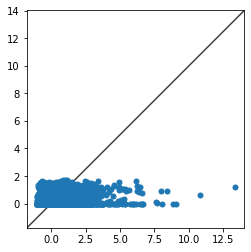

In [ ]:


los_cnn_y_test_std = np.subtract(los_cnn_y_test, np.repeat(np.mean(los_cnn_y_test), len(los_cnn_y_test))) / np.std(los_cnn_y_test)

fig, ax = plt.subplots()
ax.scatter(los_cnn_y_test_std, cnn_los_preds, s=25, zorder=10)


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

# Implementing Logistic Regression Model
def train_test_lr_model(X_train, X_test, y_train, y_test): 
    
    lr_model = LogisticRegression(random_state=random_seed, max_iter=10e6)
    
    lr_model.fit(X_train, y_train)
    
    preds = lr_model.predict_proba(X_test)
    
    auroc = metrics.roc_auc_score(y_test, preds[:,1])
    print("auroc: ", auroc, "\n")
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, preds[:,1])
    
    auprc = metrics.auc(recall, precision)
    print("auprc: ", auprc, "\n")




In [ ]:
from sklearn.linear_model import Lasso
from sklearn import metrics

# Implementing Linear Regression Model
def train_test_linear_model(X_train, X_test, y_train, y_test): 
    
    lr_model = Lasso(random_state=random_seed, max_iter=10e6)
    
    lr_model.fit(X_train, y_train)
    
    preds = lr_model.predict(X_test)
    
    mse = metrics.mean_squared_error(y_test, preds)
    print("mse: ", mse, "\n")
    
    mae = metrics.mean_absolute_error(y_test, preds)

    print("mae: ", mae, "\n")


In [ ]:
# LR mean readmission

readm_mean_X_train_2d = readm_mean_X_train.reshape((readm_mean_X_train.shape[0], readm_mean_X_train.shape[1]*readm_mean_X_train.shape[2]))

readm_mean_X_test_2d = readm_mean_X_test.reshape((readm_mean_X_test.shape[0], readm_mean_X_test.shape[1]*readm_mean_X_test.shape[2]))

train_test_lr_model(readm_mean_X_train_2d, readm_mean_X_test_2d, readm_mean_y_train, readm_mean_y_test)


auroc:  0.561354868089402 

auprc:  0.16360493245542496 



In [ ]:
# LR mean ihm


mortality_mean_X_train_2d = mortality_mean_X_train.reshape((mortality_mean_X_train.shape[0],
                                                            mortality_mean_X_train.shape[1]*mortality_mean_X_train.shape[2]))

mortality_mean_X_test_2d = mortality_mean_X_test.reshape((mortality_mean_X_test.shape[0],
                                                       mortality_mean_X_test.shape[1]*mortality_mean_X_test.shape[2]))

train_test_lr_model(mortality_mean_X_train_2d, mortality_mean_X_test_2d, mortality_mean_y_train, mortality_mean_y_test)



auroc:  0.7747496200205269 

auprc:  0.3792769789916107 



In [ ]:
# Linear regression mean los

los_mean_X_train_2d = los_mean_X_train.reshape((los_mean_X_train.shape[0], los_mean_X_train.shape[1]*los_mean_X_train.shape[2]))

los_mean_X_test_2d = los_mean_X_test.reshape((los_mean_X_test.shape[0], los_mean_X_test.shape[1]*los_mean_X_test.shape[2]))

train_test_linear_model(los_mean_X_train_2d, los_mean_X_test_2d, los_mean_y_train, los_mean_y_test)




mse:  8.787901536306133e+16 

mae:  3750157.5595066603 



In [ ]:
# LR cnn readmission


readm_cnn_X_train_2d = readm_cnn_X_train.reshape((readm_cnn_X_train.shape[0], readm_cnn_X_train.shape[1]*readm_cnn_X_train.shape[2]))

readm_cnn_X_test_2d = readm_cnn_X_test.reshape((readm_cnn_X_test.shape[0], readm_cnn_X_test.shape[1]*readm_cnn_X_test.shape[2]))

train_test_lr_model(readm_cnn_X_train_2d, readm_cnn_X_test_2d, readm_cnn_y_train, readm_cnn_y_test)


auroc:  0.560741450769777 

auprc:  0.16232186816400582 



In [ ]:
# LR cnn ihm



mortality_cnn_X_train_2d = mortality_cnn_X_train.reshape((mortality_cnn_X_train.shape[0],
                                                          mortality_cnn_X_train.shape[1]*mortality_cnn_X_train.shape[2]))

mortality_cnn_X_test_2d = mortality_cnn_X_test.reshape((mortality_cnn_X_test.shape[0],
                                                     mortality_cnn_X_test.shape[1]*mortality_cnn_X_test.shape[2]))

train_test_lr_model(mortality_cnn_X_train_2d, mortality_cnn_X_test_2d, mortality_cnn_y_train, mortality_cnn_y_test)



auroc:  0.8121227605889791 

auprc:  0.4078001630668505 



In [ ]:
# Linear regression cnn los


los_cnn_X_train_2d = los_cnn_X_train.reshape((los_cnn_X_train.shape[0], los_cnn_X_train.shape[1]*los_cnn_X_train.shape[2]))

los_cnn_X_test_2d = los_cnn_X_test.reshape((los_cnn_X_test.shape[0], los_cnn_X_test.shape[1]*los_cnn_X_test.shape[2]))

train_test_linear_model(los_cnn_X_train_2d, los_cnn_X_test_2d, los_cnn_y_train, los_cnn_y_test)





mse:  1.0 

mae:  0.6456541924088668 



In [ ]:
import xgboost as xgb

# Implementing XGBoost model
def train_test_XGBoost_class(X_train, X_test, y_train, y_test):
    xg_class = xgb.XGBClassifier(objective ='binary:logistic', nthread=1, learning_rate = 0.2,
                    max_depth = 12, alpha = 12, n_estimators = 35, use_label_encoder = False, eval_metric='logloss')
    
    xg_class.fit(X_train,y_train)

    preds = xg_class.predict_proba(X_test)
    
    auroc = metrics.roc_auc_score(y_test, preds[:,1])
    print("auroc: ", auroc, "\n")
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, preds[:,1])
    
    auprc = metrics.auc(recall, precision)
    print("auprc: ", auprc, "\n")
    

     
   


In [ ]:
def train_test_XGBoost_reg(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', nthread=1, learning_rate = 0.2,
                    max_depth = 12, alpha = 12, n_estimators = 30)
    
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    
    mse = metrics.mean_squared_error(y_test, preds)
    print("mse: ", mse, "\n")
    
    mae = metrics.mean_absolute_error(y_test, preds)
    print("mae: ", mae, "\n")
    
   

In [ ]:
# XGB mean readmission

readm_mean_X_train_2d = readm_mean_X_train.reshape((readm_mean_X_train.shape[0], readm_mean_X_train.shape[1]*readm_mean_X_train.shape[2]))

readm_mean_X_test_2d = readm_mean_X_test.reshape((readm_mean_X_test.shape[0], readm_mean_X_test.shape[1]*readm_mean_X_test.shape[2]))

train_test_XGBoost_class(readm_mean_X_train_2d, readm_mean_X_test_2d, readm_mean_y_train, readm_mean_y_test)


auroc:  0.5621806527938551 

auprc:  0.17173605577090123 



In [ ]:
# XGB mean ihm


mortality_mean_X_train_2d = mortality_mean_X_train.reshape((mortality_mean_X_train.shape[0],
                                                            mortality_mean_X_train.shape[1]*mortality_mean_X_train.shape[2]))

mortality_mean_X_test_2d = mortality_mean_X_test.reshape((mortality_mean_X_test.shape[0],
                                                       mortality_mean_X_test.shape[1]*mortality_mean_X_test.shape[2]))

train_test_XGBoost_class(mortality_mean_X_train_2d, mortality_mean_X_test_2d, mortality_mean_y_train, mortality_mean_y_test)



auroc:  0.8863928878875464 

auprc:  0.5721580850054485 



In [ ]:
# XGB mean los

los_mean_X_train_2d = los_mean_X_train.reshape((los_mean_X_train.shape[0], los_mean_X_train.shape[1]*los_mean_X_train.shape[2]))

los_mean_X_test_2d = los_mean_X_test.reshape((los_mean_X_test.shape[0], los_mean_X_test.shape[1]*los_mean_X_test.shape[2]))

train_test_XGBoost_reg(los_mean_X_train_2d, los_mean_X_test_2d, los_mean_y_train, los_mean_y_test)




mse:  0.8817036930970076 

mae:  0.5756855323663213 



In [ ]:
# XGB cnn readmission


readm_cnn_X_train_2d = readm_cnn_X_train.reshape((readm_cnn_X_train.shape[0], readm_cnn_X_train.shape[1]*readm_cnn_X_train.shape[2]))

readm_cnn_X_test_2d = readm_cnn_X_test.reshape((readm_cnn_X_test.shape[0], readm_cnn_X_test.shape[1]*readm_cnn_X_test.shape[2]))

train_test_XGBoost_class(readm_cnn_X_train_2d, readm_cnn_X_test_2d, readm_cnn_y_train, readm_cnn_y_test)


auroc:  0.547041266545549 

auprc:  0.1637594250452039 



In [ ]:
# XGB cnn ihm



mortality_cnn_X_train_2d = mortality_cnn_X_train.reshape((mortality_cnn_X_train.shape[0],
                                                          mortality_cnn_X_train.shape[1]*mortality_cnn_X_train.shape[2]))

mortality_cnn_X_test_2d = mortality_cnn_X_test.reshape((mortality_cnn_X_test.shape[0],
                                                     mortality_cnn_X_test.shape[1]*mortality_cnn_X_test.shape[2]))

train_test_XGBoost_class(mortality_cnn_X_train_2d, mortality_cnn_X_test_2d, mortality_cnn_y_train, mortality_cnn_y_test)



auroc:  0.8877444099103873 

auprc:  0.5738970708566882 



In [ ]:
# XGB cnn los


los_cnn_X_train_2d = los_cnn_X_train.reshape((los_cnn_X_train.shape[0], los_cnn_X_train.shape[1]*los_cnn_X_train.shape[2]))

los_cnn_X_test_2d = los_cnn_X_test.reshape((los_cnn_X_test.shape[0], los_cnn_X_test.shape[1]*los_cnn_X_test.shape[2]))

train_test_XGBoost_reg(los_cnn_X_train_2d, los_cnn_X_test_2d, los_cnn_y_train, los_cnn_y_test)





mse:  0.8619276186468752 

mae:  0.5699887764981945 



In [ ]:
# cross-validation xgb regression

from sklearn.model_selection import StratifiedKFold


# Grid search for XGB
depths = [12, 15]
n_ests = [30, 35]
lrs = [0.1, 0.2]
alphas = [12, 14]


auroc_dict = {}
auprc_dict = {}

for depth in depths:
    for n_est in n_ests:
        for lr in lrs:
            for alpha in alphas:

                auroc_dict[(depth, n_est, lr, alpha)] = 0
                auprc_dict[(depth, n_est, lr, alpha)] = 0

k = 4


skf = StratifiedKFold(n_splits=k)

for train_index, test_index in skf.split(mortality_mean_X_train_2d, mortality_mean_y_train):
    X_train_kf, X_test_kf = mortality_mean_X_train_2d[train_index], mortality_mean_X_train_2d[test_index]
    y_train_kf, y_test_kf = mortality_mean_y_train.iloc[train_index], mortality_mean_y_train.iloc[test_index]
  

    for depth in depths:
        for n_est in n_ests:
            for lr in lrs:
                for alpha in alphas:
                    
                    
                    xg_class = xgb.XGBClassifier(objective ='binary:logistic', nthread=1, learning_rate = lr,
                    max_depth = depth, alpha = alpha, n_estimators = n_est, use_label_encoder = False, eval_metric='logloss')
    
                    xg_class.fit(X_train_kf, y_train_kf)

                    preds = xg_class.predict_proba(X_test_kf)

                    cur_auroc = metrics.roc_auc_score(y_test_kf, preds[:,1])

                    precision, recall, thresholds = metrics.precision_recall_curve(y_test_kf, preds[:,1])

                    cur_auprc = metrics.auc(recall, precision)

                    auroc_dict[(depth, n_est, lr, alpha)] += cur_auroc / k 
                    auprc_dict[(depth, n_est, lr, alpha)] += cur_auprc / k


best_auroc = -1
best_auprc = -1

for key, model_auroc in auroc_dict.items():
    if model_auroc > best_auroc:
        best_auroc = model_auroc
        best_depth = key[0]
        best_n_est = key[1]
        best_learning_rate = key[2]
        best_alpha = key[3]


# Finding the best parameters n for mse
print('Best auroc:', best_auroc, '\n')
print('depth:', best_depth, '\n')
print('n_est:', best_n_est, '\n')
print('learning rate: ', best_learning_rate, '\n')
print('alpha: ', best_alpha, '\n')

for key, model_auprc in auprc_dict.items():
    if model_auprc > best_auprc:
        best_auprc = model_auprc
        best_depth = key[0]
        best_n_est = key[1]
        best_learning_rate = key[2]
        best_alpha = key[3]
  
 # Finding the best parameters n for mae
print('Best auprc:', best_auprc, '\n')
print('depth:', best_depth, '\n')
print('n_est:', best_n_est, '\n')
print('learning rate: ', best_learning_rate, '\n')
print('alpha: ', best_alpha, '\n')


Best auroc: 0.6507959216063358 

depth: 12 

n_est: 35 

learning rate:  0.2 

alpha:  12 

Best auprc: 0.5717182456854938 

depth: 12 

n_est: 35 

learning rate:  0.2 

alpha:  12 

